In [122]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd
import sklearn.metrics as metrics

In [123]:
import sklearn
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


In [124]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(8,8)})

In [128]:
dtype_dic= {"name":str,"JHparams":str,"lenA":int,"lenB":int,"msa":int,"msaA":int,"msaB":int,"cdhit":int,"dockQ":float,"fnat":float,"iRMS":float,"LRMS":float,"fnonnat":float,"mm":float,"tmA":float,"tmB":float,"long":int,"med":int,"longPPV":float,"medPPV":float,"longA":int,"medA":int,"longPPVA":float,"medPPVA":float,"longB":int,"medB":int,"longPPVB":float,"medPPVB":float,"short":int,"shortPPV":float,"shortA":int,"shortPPVA":float,"shortB":int,"shortPPVB":float,"shortpdb":int,"medpdb":int,"longpdb":int,"avprob":float,"longMODEL":int,"medMODEL":int,"longPPVMODEL":float,"medPPVMODEL":float,"longAMODEL":int,"medAMODEL":int,"longPPVAMODEL":float,"medPPVAMODEL":float,"longBMODEL":int,"medBMODEL":int,"longPPVBMODEL":float,"medPPVBMODEL":float,"shortMODEL":int,"shortPPVMODEL":float,"shortAMODEL":int,"shortPPVAMODEL":float,"shortBMODEL":int,"shortPPVBMODEL":float,"shortpdbMODEL":float,"medpdbMODEL":float,"longpdbMODEL":float,"avprobMODEL":float,"evalue":float,"seqid":float,"hhprob":float,"hhevalue":float,"hhscore":float,"PconsDock":float,"MMdock":float,"shortMCC":float,"medMCC":float,"longMCC":float,"shortF1":float,"medF1":float,"longF1":float,"shortMCCMODEL":float,"medMCCMODEL":float,"longMCCMODEL":float,"shortF1MODEL":float,"medF1MODEL":float,"longF1MODEL":float,"rank":int,"pcd":float,"mmd":float ,"taxa":int}
df=pd.read_csv("~/Downloads/summary.csv",sep=",",dtype=dtype_dic,warn_bad_lines=True,error_bad_lines=True,na_values=-1,index_col=False)



In [130]:
#print ("Original len:", len(df))
df=df.replace(np.nan, -1.)
#df=df.dropna(axis=0, how="any")
#print (df.loc[df.JHparams=="N3-pdb"])
df=df.dropna()
#print ("After skipping:", len(df))

#print (df.loc[df.JHparams=="N3-pdb"])
#print (df.taxa)
#sys.exit()

df["code"]=df["name"].str[:4]
df["CODE"]=df["code"]
df["params"]=df["JHparams"]
datasets=df.JHparams.unique()


In [131]:
df["tmAB"]=df[["tmA","tmB"]].mean(axis=1)
df["msaAB"]=df[["msaA","msaB"]].mean(axis=1)
df["tmAB_max"]=df[["tmA","tmB"]].max(axis=1)
df["msaAB_max"]=df[["msaA","msaB"]].max(axis=1)
df["tmAB_min"]=df[["tmA","tmB"]].min(axis=1)
df["msaAB_min"]=df[["msaA","msaB"]].min(axis=1)
df["numcorrect"]=df["longPPV"]*df["long"]
df["len"]=df["lenA"]+df["lenB"]
df["TPR"]=df.numcorrect/df.longpdb


In [132]:
# Some renaming
df=df.replace({
        '-N 1 -E 1.e-10 --cpu 8 ':'N1',
        '-N 1 -E 1.e-2':'N1b',
        '-N 3 --cpu 8':'N3',
        '-N 5 --cpu 8':'N5',
        'AF2-smallbsd':'AF2-smallBFD',
        'AF2-smallbfd':'AF2-smallBFD',
        'confold':'pyconsFold',
        'confold-pdb':'pyconsFold-pdb',
        'confold-merged':'pyconsFold-merged',
        'confold-contacts':'pyconsFold-contacts',
        })

df=df.rename(columns={
        "cdhit":"Meff",
        "MMdock":"MMpair",
        "mmd":"MMcons",
        "PconsDock":"dockQpair",
        "pcd":"dockQcons",
        "long":"contacts",
        "longPPV":"PPV",
        "longMCC":"MCC",
        "longF1":"F1",
        "longpdb":"Native Contacts",
        "hhprob":"HHprob"
})


In [133]:
# Define some sets
protocolset=['N3',"pyconsFold","RaptorX","N3-merged","N3-pdb"]
oneset=['N3']
smallset=['N1','N3', 'N5']
taxaset=["N1","N1-all",'N3','N3-bact',"N3-all"]
PconsDockset=["N3",'PconsDock-dockQ','PconsDock-dockQcons','PconsDock-MMcons','PconsDock-dockQpair','PconsDock-MMpair']
Rosettaset=['N1','N3', 'N1-cov90','N3-cov90',"N1-minprob25","N3-minprob25"] 
AF2set=["AF2-merged","AF2-smallBFD","AF2-proteomes"]
PconsDockset2=Rosettaset+['PconsDock-dockQ','PconsDock-dockQcons']
RosettasetA=['N1', 'N3-cov90',"N1-minprob25"] 
RosettasetB=['N3', 'N1-cov90',"N3-minprob25"] 
#Rosettaset=['N1-cov90','N3-cov90',"N1-minprob25","N3-minprob25"] 
#RosettasetA=[ 'N3-cov90'] 
#RosettasetB=[ 'N1-cov90'] 
bigset=['N1','N3','N5', 'N1-cov90','N3-cov90', 'N1-cov50','N3-cov50',"N1-minprob25","N3-minprob25","N3-pdb","N3-merged","pyconsFold","rbh","rbh-jh"] # ,"PconsDock","pyconsFold"] 
comboset=Rosettaset+['N1-N3-multimerged', 'N1-N3-new', 'N1-N3-cov90', 'N1-N3-cov-nocov'] +["PconsDock"] 
dockingset=["gramm","gramm-contact","gramm-raptorx","TMdock-double","PconsDock"]
#dockingset=["gramm","TMdock-double","PconsDock","AF2-merged","AF2-smallBFD","AF2-proteomes"]
#dockingset=["gramm","gramm-contact","gramm-raptorx","TMdock-double","PconsDock","AF2-merged"]
grammset=["gramm","gramm-contact","gramm-trmodels","gramm-raptorx","gramm-score","gramm-score2"]
pyconsFoldset=["pyconsFold","pyconsFold-pdb","pyconsFold-contacts","N3"] # "pyconsFold-npz", ,"pyconsFold-merged" ,"pdbpyconsFold"
allset=list(set(Rosettaset+comboset+dockingset+grammset+AF2set))


In [134]:
df["log10 Meff"]=df.Meff.apply(lambda x:(np.log10(x+0.1)))
df["log10 Meff-int"]=df["log10 Meff"].astype(int)
df["log10 avprob"]=df.avprob.apply(lambda x:(np.log10(x+0.1)))
df["log10 HHprob"]=df.HHprob.apply(lambda x:(np.log10(x+0.1)))
df["log10 contacts"]=df.contacts.apply(lambda x:(np.log10(x+0.1)))
df["log10 contacts-int"]=df["log10 contacts"].astype(int)
df["log10 med"]=df.med.apply(lambda x:(np.log10(x+0.1)))
df["log10 med-int"]=df["log10 med"].astype(int)
df["log10 short"]=df.short.apply(lambda x:(np.log10(x+0.1)))
df["log10 short-int"]=df["log10 short"].astype(int)
df["log10 Native Contacts"]=df["Native Contacts"].apply(lambda x:(np.log10(x+0.1)))
df["log10 Native Contacts-int"]=df["log10 Native Contacts"].astype(int)
df["log10 medpdb"]=df.medpdb.apply(lambda x:(np.log10(x+0.1)))
df["log10 medpdb-int"]=df["log10 medpdb"].astype(int)
df["log10 shortpdb"]=df.shortpdb.apply(lambda x:(np.log10(x+0.1)))
df["log10 shortpdb-int"]=df["log10 shortpdb"].astype(int)
df["log10 hhevalue"]=df.hhevalue.apply(lambda x:(np.log10(x+0.1)))
#keys=[ 'Meff',"msa", 'contacts',"med", 'shortpdb', 'HHprob',"seqid","log10 hhevalue",'dockQpair', 'MMpair', 'MCC', 'F1', 'medMCC', 'medF1', 'shortMCC', 'shortF1', 'TMscore', 'len',"log10 Meff","log10 contacts","dockQcons","MMcons","shortpdb","medpdb","Native Contacts","avprob","log10 avprob","log10 HHprob","shortMODEL","medMODEL","longMODEL","shortPPVMODEL","medPPVMODEL","longPPVMODEL"] # 
skipkeys=set(["name","params","JHparams","code","CODE"])

skipkeys2=set(["avprob","avprobMODEL","evalue","hhevalue","lenA","lenB","len","log10 avprob","log10 hhevalue","longAMODEL","longBMODEL","longA","longB","longpdbMODEL","longMODEL","longPPVAMODEL","longPPVBMODEL","medAMODEL","medBMODEL","medpdbMODEL","medPPVAMODEL","medPPVBMODEL","MSA_max","MSA_min","MSA","msaA","msa","msaB","rank","seqid","shortAMODEL","shortMODEL","shortBMODEL","shortA","shortB","shortF1MODEL","shortMCCMODEL","shortMODEL","shortpdbMODEL","shortPPVAMODEL","shortPPVMODEL","shortPPVBMODEL","short","TMscore_max","TMscore_min","tmA","tmB"])  # No information

skipkeys3=set(["fnat","fnonnat","iRMS","longPPVA","longPPVB","LRMS","medA","med","medB","short","shortA","shortB","medF1","medPPVA","medMCC","medPPV","medPPVB","numcorrect","shortF1","shortMCC","shortPPVA","shortPPVB","shortPPV"]) # Actually decribes the structure (kept mm and dockQ) # ,"F1"
allkeys=set(df.keys())
mykeys=allkeys-skipkeys-skipkeys2-skipkeys3
print (mykeys)
#sys.exit()
#selset=["PconsDock"]
sets2={"Rosettaset":Rosettaset,"AF2set":AF2set} #,"N-test":["N1","N3"] # ,"N5" "PconsDock":["PconsDock"],
mets=[ 'dockQpair', 'dockQcons','MMpair','MMcons', 'Meff', 'contacts', 'TMscore', 'longPPVMODEL','log10 avprob','HHprob','log10 Meff','log10 HHprob']
modset=["dockQpair", "MMpair","dockQcons","MMcons"]
predset=["log10 avprob","contacts"]
seqset=["log10 Meff","HHprob"]
tmset=["TMscore","longPPVMODEL"]
cheatset=["F1","MCC","shortF1","medF1"]
methodsets={"modelinfo":modset,
            "seqinfo":seqset,
            "structinfo":tmset,
            "predinfo":predset,
            "cheatinfo":cheatset,
            "m+s-info":modset+seqset,
            "m+t-info":modset+seqset,
            "m+s+t-info":modset+seqset+tmset,
            "m+s+p-info":modset+seqset+predset,
            "m+s+p+t-info":modset+seqset+predset+tmset,
            "s+p-info":seqset+predset,
            "m+p-info":modset+seqset,
            "s+p+t-info":seqset+predset+tmset,
            "m+p+t-info":modset+seqset+tmset,
            "MMcons+Meff":["MMcons","Meff"],
            "dockQcons+Meff":["dockQcons","Meff"],
            "dockQpair+Meff":["dockQpair","Meff"],
            "MMpair+Meff":["MMpair","Meff"],
            "MMcons+HHprob":["MMcons","HHprob"],
            "dockQcons+HHprob":["dockQcons","HHprob"],
            "dockQpair+HHprob":["dockQpair","HHprob"],
            "MMpair+HHprob":["MMpair","HHprob"],
            "MMcons+longPPVMODEL":["MMcons","longPPVMODEL"],
            "dockQcons+longPPVMODEL":["dockQcons","longPPVMODEL"],
            "dockQpair+longPPVMODEL":["dockQpair","longPPVMODEL"],
            "MMpair+longPPVMODEL":["MMpair","longPPVMODEL"],
            "mets":mets
}
for k in mykeys:
    methodsets[k]=[k]

# Examples
firstsets={"Rosettaset":"N3","PconsDockset":"N3","PconsDockset2":"N3","bigset":"PconsDock","dockingset":"gramm","grammset":"gramm","pyconsFoldset":"pyconsFold","smallset":"N3","Jackhmmer":"N3","protocolset":"N3","taxaset":"N3","AF2set":"AF2-merged"}
setdata={"Rosettaset":Rosettaset,"AF2set":AF2set,"bigset":bigset,"dockingset":dockingset,"grammset":grammset,"pyconsFoldset":pyconsFoldset,"PconsDockset":PconsDockset,"PconsDockset2":PconsDockset2,"smallset":smallset,"Jackhmmer":oneset,"protocolset":protocolset,"taxaset":taxaset}

cutoff=.23


{'log10 med', 'log10 short', 'log10 medpdb-int', 'taxa', 'msaAB', 'tmAB_max', 'medpdb', 'msaAB_max', 'MCC', 'tmAB_min', 'medMODEL', 'log10 shortpdb-int', 'dockQ', 'contacts', 'dockQcons', 'log10 Meff', 'MMpair', 'mm', 'hhscore', 'MMcons', 'tmAB', 'log10 HHprob', 'log10 short-int', 'longF1MODEL', 'log10 Native Contacts', 'shortpdb', 'log10 med-int', 'log10 contacts-int', 'log10 medpdb', 'TPR', 'log10 Native Contacts-int', 'PPV', 'medPPVMODEL', 'longMCCMODEL', 'F1', 'log10 contacts', 'log10 shortpdb', 'HHprob', 'longPPVMODEL', 'Native Contacts', 'Meff', 'medMCCMODEL', 'msaAB_min', 'medF1MODEL', 'log10 Meff-int', 'dockQpair'}


In [135]:

# We have to think which ones to use..
df2=df.loc[df.JHparams.isin(Rosettaset)].copy()
df2.JHparams="PconsDock"
df2.params="PconsDock"
columns=df2.keys()
df3=pd.DataFrame(columns=columns)
# we need too update the ranks
df2.sort_values("dockQpair",axis=0,inplace=True)
#print(df2.keys())
for code in df2["code"].unique():
    tempdf=df2.loc[df2["code"]==code]
    tempdf["rank"]=tempdf["dockQcons"].rank(method="first",ascending=False)
    df3=pd.concat([df3,tempdf],ignore_index=True)
df=pd.concat([df,df3], ignore_index=True,sort=False)


for i in ["dockQ","MMcons","dockQcons","MMpair","dockQpair"]:
    # We have to think which ones to use..
    df2=df.loc[df.JHparams.isin(Rosettaset)].copy()
    df2.JHparams="PconsDock-"+str(i)
    df2.params="PconsDock-"+str(i)
    columns=df2.keys()
    df3=pd.DataFrame(columns=columns)
    # we need too update the ranks
    df2.sort_values(i,axis=0,inplace=True)
    #print(df2.keys())
    for code in df2["code"].unique():
        tempdf=df2.loc[df2["code"]==code]
        tempdf["rank"]=tempdf[i].rank(method="first",ascending=False)
        df3=pd.concat([df3,tempdf],ignore_index=True)
    df=pd.concat([df,df3], ignore_index=True,sort=False)


#sys.exit(0)
# More PconsDock variations
sets={"Rosettaset":Rosettaset,"AF2set":AF2set,"bigset":bigset,"dockingset":dockingset,"pyconsFoldset":pyconsFoldset,"grammset":grammset,"PconsDockset":PconsDockset,"PconsDockset2":PconsDockset2,"Jackhmmer":oneset,"smallset":smallset,"protocolset":protocolset,"taxaset":taxaset}


methods=["dockQpair", "MMpair","dockQcons","MMcons"] # "dockQ", 

allrosetta=Rosettaset+["PconsDock"]
for s in sets.keys():
    print (s,sets[s])
    for m in methods:
        # We have to think which ones to use..
        df2=df.loc[df.JHparams.isin(sets[s])].copy()
        df2.JHparams=s+"-"+m
        df2.params=s+"-"+m

        columns=df2.keys()
        df3=pd.DataFrame(columns=columns)

        # we need tpo update the ranks
        df2.sort_values(m,axis=0,inplace=True)
        #print(df2.keys())
        for code in df2["code"].unique():
            tempdf=df2.loc[df2["code"]==code]
            tempdf["rank"]=tempdf[m].rank(method="first",ascending=False)
            df3=pd.concat([df3,tempdf],ignore_index=True)
        df=pd.concat([df,df3], ignore_index=True,sort=False)
        allrosetta+=[s+"-"+m]


df["TMscore"]=df[["tmA","tmB"]].mean(axis=1)
df["MSA"]=df[["msaA","msaB"]].mean(axis=1)
df["TMscore_max"]=df[["tmA","tmB"]].max(axis=1)
df["MSA_max"]=df[["msaA","msaB"]].max(axis=1)
df["TMscore_min"]=df[["tmA","tmB"]].min(axis=1)
df["MSA_min"]=df[["msaA","msaB"]].min(axis=1)
df["numcorrect"]=df["PPV"]*df["contacts"]
df["len"]=df["lenA"]+df["lenB"]


<ipython-input-135-8cf4959e893c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf["rank"]=tempdf["dockQcons"].rank(method="first",ascending=False)


<ipython-input-135-8cf4959e893c>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf["rank"]=tempdf[i].rank(method="first",ascending=False)


Rosettaset ['N1', 'N3', 'N1-cov90', 'N3-cov90', 'N1-minprob25', 'N3-minprob25']


<ipython-input-135-8cf4959e893c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf["rank"]=tempdf[m].rank(method="first",ascending=False)


AF2set ['AF2-merged', 'AF2-smallBFD', 'AF2-proteomes']


bigset ['N1', 'N3', 'N5', 'N1-cov90', 'N3-cov90', 'N1-cov50', 'N3-cov50', 'N1-minprob25', 'N3-minprob25', 'N3-pdb', 'N3-merged', 'pyconsFold', 'rbh', 'rbh-jh']


dockingset ['gramm', 'gramm-contact', 'gramm-raptorx', 'TMdock-double', 'PconsDock']


pyconsFoldset ['pyconsFold', 'pyconsFold-pdb', 'pyconsFold-contacts', 'N3']


grammset ['gramm', 'gramm-contact', 'gramm-trmodels', 'gramm-raptorx', 'gramm-score', 'gramm-score2']


PconsDockset ['N3', 'PconsDock-dockQ', 'PconsDock-dockQcons', 'PconsDock-MMcons', 'PconsDock-dockQpair', 'PconsDock-MMpair']


PconsDockset2 ['N1', 'N3', 'N1-cov90', 'N3-cov90', 'N1-minprob25', 'N3-minprob25', 'PconsDock-dockQ', 'PconsDock-dockQcons']


Jackhmmer ['N3']


smallset ['N1', 'N3', 'N5']


protocolset ['N3', 'pyconsFold', 'RaptorX', 'N3-merged', 'N3-pdb']


taxaset ['N1', 'N1-all', 'N3', 'N3-bact', 'N3-all']


In [136]:

df["TMscore"]=df[["tmA","tmB"]].mean(axis=1)
df["MSA"]=df[["msaA","msaB"]].mean(axis=1)
df["TMscore_max"]=df[["tmA","tmB"]].max(axis=1)
df["MSA_max"]=df[["msaA","msaB"]].max(axis=1)
df["TMscore_min"]=df[["tmA","tmB"]].min(axis=1)
df["MSA_min"]=df[["msaA","msaB"]].min(axis=1)
df["numcorrect"]=df["PPV"]*df["contacts"]
df["len"]=df["lenA"]+df["lenB"]


In [137]:
codes=df.code.unique()
df_mean=df.groupby(["JHparams","code"]).mean()
df_max=df.groupby(["JHparams","code"]).max()
df_min=df.groupby(["JHparams","code"]).min()
df_first=df.loc[df["rank"]==1]
#df_max["JHparams"]=df_max["params"]
#df_min["JHparams"]=df_min["params"]
#df_mean["JHparams"]=df_mean["params"]



In [138]:
# Max/min/mean
datasets=df.JHparams.unique()
print (datasets)
data_mean={}
data_max={}
data_min={}
for d in datasets:
    print (d)
    data_mean[d]=df.loc[df.JHparams==d].groupby(["code"]).mean()
    data_max[d]=df.loc[df.JHparams==d].groupby(["code"]).max()
    data_min[d]=df.loc[df.JHparams==d].groupby(["code"]).min()

#print (data_max["N3-pdb"])
#sys.exit()
data_first={}
data_second={}
for d in datasets:
    data_first[d]=df.loc[ (df["JHparams"]==d)  & (df["rank"]==1)]
    data_second[d]=df.loc[ (df["JHparams"]==d)  & (df["rank"]==2)]


['N3' 'AF2-merged' 'AF2-proteomes' 'AF2-smallBFD' 'pyconsFold-contacts'
 'pyconsFold-merged' 'confold-npz' 'pyconsFold-pdb' 'confold-plm'
 'pyconsFold' 'confold-raptorx' 'gramm-contact' 'gramm' 'gramm-raptorx'
 'gramm-score2' 'gramm-score' 'gramm-trmodels' 'N1-all' '-N 1 -E 1.e-2 '
 'N1-cov50' 'N1-cov90-minprob25' 'N1-cov90' 'N1-minprob25' 'N1-N3-cov90'
 'N1-N3-cov-nocov' 'N1-N3-new' 'N1-N3-multimerged' 'N1' 'N3-all' 'N3-bact'
 'N3-cov50' 'N3-cov90-minprob25' 'N3-cov90' 'N3-merged' 'N3-minprob25'
 'N3-pdb' 'RoseTTAFold-N3-E2E' 'RoseTTAFold-N3-pyRosetta' 'N5'
 'pdbconfold' 'RaptorX' 'rbh-jh' 'rbh' 'RoseTTAFold-hhblits-merged'
 'RoseTTAFold-merged-pyRosetta' 'TMdock-double' 'TMdock-nohomology'
 'TMdock' 'PconsDock' 'PconsDock-dockQ' 'PconsDock-MMcons'
 'PconsDock-dockQcons' 'PconsDock-MMpair' 'PconsDock-dockQpair'
 'Rosettaset-dockQpair' 'Rosettaset-MMpair' 'Rosettaset-dockQcons'
 'Rosettaset-MMcons' 'AF2set-dockQpair' 'AF2set-MMpair' 'AF2set-dockQcons'
 'AF2set-MMcons' 'bigset-dockQpair

AF2-merged


AF2-proteomes


AF2-smallBFD


pyconsFold-contacts


pyconsFold-merged


confold-npz


pyconsFold-pdb


confold-plm


pyconsFold


confold-raptorx


gramm-contact


gramm


gramm-raptorx


gramm-score2


gramm-score


gramm-trmodels


N1-all


-N 1 -E 1.e-2 


N1-cov50


N1-cov90-minprob25


N1-cov90


N1-minprob25


N1-N3-cov90


N1-N3-cov-nocov


N1-N3-new


N1-N3-multimerged


N1


N3-all


N3-bact


N3-cov50


N3-cov90-minprob25


N3-cov90


N3-merged


N3-minprob25


N3-pdb


RoseTTAFold-N3-E2E


RoseTTAFold-N3-pyRosetta


N5


pdbconfold


RaptorX


rbh-jh


rbh


RoseTTAFold-hhblits-merged


RoseTTAFold-merged-pyRosetta


TMdock-double


TMdock-nohomology


TMdock


PconsDock


PconsDock-dockQ


PconsDock-MMcons


PconsDock-dockQcons


PconsDock-MMpair


PconsDock-dockQpair


Rosettaset-dockQpair


Rosettaset-MMpair


Rosettaset-dockQcons


Rosettaset-MMcons


AF2set-dockQpair


AF2set-MMpair


AF2set-dockQcons


AF2set-MMcons


bigset-dockQpair


bigset-MMpair


bigset-dockQcons


bigset-MMcons


dockingset-dockQpair


dockingset-MMpair


dockingset-dockQcons


dockingset-MMcons


pyconsFoldset-dockQpair


pyconsFoldset-MMpair


pyconsFoldset-dockQcons


pyconsFoldset-MMcons


grammset-dockQpair


grammset-MMpair


grammset-dockQcons


grammset-MMcons


PconsDockset-dockQpair


PconsDockset-MMpair


PconsDockset-dockQcons


PconsDockset-MMcons


PconsDockset2-dockQpair


PconsDockset2-MMpair


PconsDockset2-dockQcons


PconsDockset2-MMcons


Jackhmmer-dockQpair


Jackhmmer-MMpair


Jackhmmer-dockQcons


Jackhmmer-MMcons


smallset-dockQpair


smallset-MMpair


smallset-dockQcons


smallset-MMcons


protocolset-dockQpair


protocolset-MMpair


protocolset-dockQcons


protocolset-MMcons


taxaset-dockQpair


taxaset-MMpair


taxaset-dockQcons


taxaset-MMcons


In [139]:
good=df.loc[(df.JHparams.isin(bigset))&(df.dockQ>.23)]
good

name JHparams lenA lenB   msa   msaA   msaB  Meff  \
0      1ay7_u1_A-1ay7_u2_A       N3   97   90  1060   1485   2034  1026   
1      1ay7_u2_A-1ay7_u1_A       N3   90   97  1060   2034   1485   989   
34     1gpw_u1_A-1gpw_u2_A       N3  252  204  7137  58466  67629  5348   
35     1gpw_u2_A-1gpw_u1_A       N3  204  252  7137  67629  58466  5343   
86     1v5i_u1_A-1v5i_u2_A       N3  276   78  1922  54177  12066  1642   
...                    ...      ...  ...  ...   ...    ...    ...   ...   
38469  2zae_u1_A-2zae_u2_A   rbh-jh  107   93   350   1659   1521   262   
38470  2zae_u2_A-2zae_u1_A   rbh-jh   93  107   350   1521   1659   266   
38717  1gpw_u1_A-1gpw_u2_A      rbh  252  204  5619  58466  67629   447   
38777  2o3b_u1_A-2o3b_u2_A      rbh  240  144   100   5431    518    61   
38785  2zae_u1_A-2zae_u2_A      rbh  107   93   253   1659   1521   100   

       dockQ   fnat  ...  log10 medpdb-int  log10 shortpdb  \
0      0.281  0.167  ...                 1        0.612784   
1      0.239  0.250  ...                 1        0.612784   
34     0.351  0.320  ...                 1        0.908485   
35     0.354  0.293  ...                 1        0.908485   
86     0.336  0.191  ...                 1        0.707570   
...      ...    ...  ...               ...             ...   
38469  0.433  0.371  ...                 1        0.785330   
38470  0.446  0.387  ...                 1        0.785330   
38717  0.327  0.280  ...                 1        0.908485   
38777  0.236  0.167  ...                 1       -1.000000   
38785  0.432  0.339  ...                 1        0.785330   

       log10 shortpdb-int  log10 hhevalue   TMscore      MSA TMscore_max  \
0                       0       -0.301030  0.829400   1759.5     0.84371   
1                       0        3.999961  0.816405   1759.5     0.84123   
34                      0        0.113943  0.885775  63047.5     0.89246   
35                      0        0.041393  0.889770  63047.5     0.89718   
86                      0       -0.301030  0.818890  33121.5     0.88557   
...                   ...             ...       ...      ...         ...   
38469                   0        3.999961  0.843960   1590.0     0.84524   
38470                   0        3.999961  0.837095   1590.0     0.83869   
38717                   0        0.113943  0.888810  63047.5     0.88970   
38777                  -1       -0.522879  0.686785   2974.5     0.76730   
38785                   0        3.999961  0.844845   1590.0     0.85447   

       MSA_max  TMscore_min  MSA_min  
0       2034.0      0.81509   1485.0  
1       2034.0      0.79158   1485.0  
34     67629.0      0.87909  58466.0  
35     67629.0      0.88236  58466.0  
86     54177.0      0.75221  12066.0  
...        ...          ...      ...  
38469   1659.0      0.84268   1521.0  
38470   1659.0      0.83550   1521.0  
38717  67629.0      0.88792  58466.0  
38777   5431.0      0.60627    518.0  
38785   1659.0      0.83522   1521.0  

[156 rows x 118 columns]

In [140]:
cutoff=0.23
df.loc[(df.dockQ>cutoff),"goodmodels"]=True
df.loc[(df.dockQ<=cutoff),"goodmodels"]=False
good.loc[(good.dockQ>cutoff),"goodmodels"]=True
good.loc[(good.dockQ<=cutoff),"goodmodels"]=False


/home/arnee/.local/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/arnee/.local/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


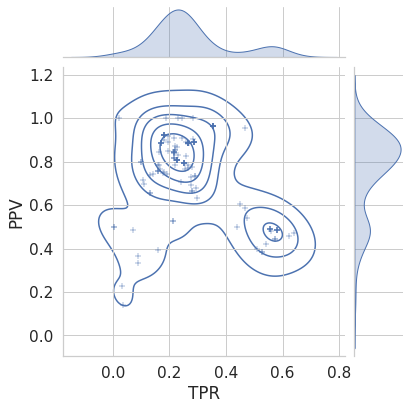

In [141]:
newdf=good.loc[good.JHparams.isin(bigset)]
sns.set(style="whitegrid",rc={'figure.figsize':(12,12)}, font_scale=1.4)
jplot=sns.jointplot(data=newdf, x="TPR", y="PPV",hue="goodmodels",kind="scatter",marker="+",legend=False)
jplot.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6,legend=False)
#sns_plot=sns.jointplot(data=newdf, x=k, y=l,hue="good",kind="kde")
#jplot.title="Good models: "
jplot.savefig("jointplot-good-models-TPR-PPV.png",bbox_inches="tight",dpi=600)


In [142]:
for i in ["dockQ","MMcons","dockQcons","MMpair","dockQpair","tmAB"]:
    # We have to think which ones to use..
    df2=df.loc[df.JHparams.isin(Rosettaset)].copy()
    df2.JHparams="PconsDock-"+str(i)
    df2.params="PconsDock-"+str(i)
    columns=df2.keys()
    df3=pd.DataFrame(columns=columns)
    # we need too update the ranks
    df2.sort_values(i,axis=0,inplace=True)
    #print(df2.keys())
    for code in df2["code"].unique():
        tempdf=df2.loc[df2["code"]==code]
        tempdf["rank-"+i]=tempdf[i].rank(method="first",ascending=False)
        df3=pd.concat([df3,tempdf],ignore_index=True)
    df=pd.concat([df,df3], ignore_index=True,sort=False)


<ipython-input-142-0ef453541fa2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf["rank-"+i]=tempdf[i].rank(method="first",ascending=False)


In [100]:
df2=df.loc[df.JHparams.isin(Rosettaset)].copy()
df2

name JHparams lenA lenB   msa    msaA    msaB  Meff  \
0      1ay7_u1_A-1ay7_u2_A       N3   97   90  1060    1485    2034  1026   
1      1ay7_u2_A-1ay7_u1_A       N3   90   97  1060    2034    1485   989   
2      1b27_u1_A-1b27_u2_A       N3  109   90   733    1484    2034   654   
3      1b27_u2_A-1b27_u1_A       N3   90  109   733    2034    1484   656   
4      1bdj_u1_A-1bdj_u2_A       N3  129  118  5651  349880   23051  5071   
...                    ...      ...  ...  ...   ...     ...     ...   ...   
31410  5cec_u2_A-5cec_u1_A       N3  191  403  1274  309307   30621   770   
31411  5cra_u1_A-5cra_u2_A       N3  193   77     1      11   38383     1   
31412  5cra_u2_A-5cra_u1_A       N3   77  193     1   38383      11     1   
31413  5eg3_u1_A-5eg3_u2_A       N3  303  105   421  565997   25926   101   
31414  5eg3_u2_A-5eg3_u1_A       N3  105  303   421   25926  565997   103   

       dockQ   fnat  ...  log10 medpdb-int  log10 shortpdb  \
0      0.281  0.167  ...                 1        0.612784   
1      0.239  0.250  ...                 1        0.612784   
2      0.223  0.120  ...                 1        1.004321   
3      0.229  0.160  ...                 1        1.004321   
4      0.000  0.000  ...                 1        0.322219   
...      ...    ...  ...               ...             ...   
31410  0.002  0.000  ...                 2        1.303196   
31411  0.008  0.000  ...                 1        0.908485   
31412  0.061  0.036  ...                 1        0.785330   
31413  0.000  0.000  ...                 0       -1.000000   
31414  0.000  0.000  ...                -1       -1.000000   

       log10 shortpdb-int  log10 hhevalue   TMscore       MSA TMscore_max  \
0                       0       -0.301030  0.829400    1759.5     0.84371   
1                       0        3.999961  0.816405    1759.5     0.84123   
2                       1        0.278754  0.824750    1759.0     0.85428   
3                       1        0.414973  0.805310    1759.0     0.82261   
4                       0        3.999961  0.862585  186465.5     0.92789   
...                   ...             ...       ...       ...         ...   
31410                   1       -0.522879  0.608870  169964.0     0.83553   
31411                   0        0.041393  0.546110   19197.0     0.71106   
31412                   0       -0.045757  0.562420   19197.0     0.78769   
31413                  -1       -0.096910  0.713410  295961.5     0.74386   
31414                  -1       -0.154902  0.656255  295961.5     0.76252   

        MSA_max  TMscore_min  MSA_min  
0        2034.0      0.81509   1485.0  
1        2034.0      0.79158   1485.0  
2        2034.0      0.79522   1484.0  
3        2034.0      0.78801   1484.0  
4      349880.0      0.79728  23051.0  
...         ...          ...      ...  
31410  309307.0      0.38221  30621.0  
31411   38383.0      0.38116     11.0  
31412   38383.0      0.33715     11.0  
31413  565997.0      0.68296  25926.0  
31414  565997.0      0.54999  25926.0  

[2998 rows x 118 columns]

In [82]:
for i in ["dockQ","MMcons","dockQcons","MMpair","dockQpair","tmAB"]:
    # We have to think which ones to use..
    df2=df.loc[df.JHparams.isin(Rosettaset)].copy()
    df2.JHparams="PconsDock-"+str(i)
    df2.params="PconsDock-"+str(i)
    columns=df2.keys()
    df3=pd.DataFrame(columns=columns)
    # we need too update the ranks
    df2.sort_values(i,axis=0,inplace=True)
    #print(df2.keys())
    for code in df2["code"].unique():
        tempdf=df2.loc[df2["code"]==code]
        tempdf["rank-"+i]=tempdf[i].rank(method="first",ascending=False)
        df3=pd.concat([df3,tempdf],ignore_index=True)
    #df=pd.concat([df,df3], ignore_index=True,sort=False)


<ipython-input-82-6c88e6aca6fa>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf["rank-"+i]=tempdf[i].rank(method="first",ascending=False)


In [97]:
df2=df.loc[df.JHparams.isin(Rosettaset)].copy()

In [110]:
i="dockQ"
code="1ay7"
for i in ["dockQ","MMcons","dockQcons","MMpair","dockQpair","tmAB"]:
#tempdf
    df2=df.loc[df.JHparams.isin(Rosettaset)].copy()
    columns=df2.keys()
    df3=pd.DataFrame(columns=columns)
    for code in df2["code"].unique():
        tempdf=df2.loc[df2["code"]==code]
        tempdf["rank-"+i]=tempdf[i].rank(method="first",ascending=False)
        df3=pd.concat([df3,tempdf],ignore_index=True)
    test=pd.concat([df,df3], ignore_index=True,sort=False)
    df3[["code",i,"rank-"+i]]
    average=df3.loc[df3["rank-"+i]==1]["dockQ"].mean()
    num=df3.loc[(df3["rank-"+i]==1)&(df3.dockQ>0.23)]["dockQ"].count()

    print (i,average,num)


<ipython-input-110-6f9f8455e5b0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf["rank-"+i]=tempdf[i].rank(method="first",ascending=False)


dockQ 0.06932407407407408 15


MMcons 0.03922685185185185 9


dockQcons 0.04038888888888889 10


MMpair 0.03576851851851852 8


dockQpair 0.041962962962962966 7


tmAB 0.030180555555555558 8


In [113]:
df.loc[(df.JHparams=="N3")&(df["rank"]==1)].dockQ.mean()

0.02216203703703704

In [114]:
sns.set(font_scale=1.4,style="whitegrid",rc={'figure.figsize':(12,12)})

In [80]:
newdf=df.loc[df.JHparams.isin(Rosettaset)]
newdf[["name","JHparams","dockQ","rank","rankdockQ","ranktmAB"]].sort_values("name")

name      JHparams  dockQ  rank  rankdockQ  ranktmAB
0      1ay7_u1_A-1ay7_u2_A            N3  0.281   1.0        NaN       NaN
27206  1ay7_u1_A-1ay7_u2_A            N1  0.023   1.0        NaN       NaN
30983  1ay7_u1_A-1ay7_u2_A            N3  0.281   1.0        NaN       NaN
25049  1ay7_u1_A-1ay7_u2_A  N1-minprob25  0.043   1.0        NaN       NaN
30125  1ay7_u1_A-1ay7_u2_A  N3-minprob25  0.310   1.0        NaN       NaN
...                    ...           ...    ...   ...        ...       ...
29783  5eg3_u2_A-5eg3_u1_A      N3-cov90  0.010   2.0        NaN       NaN
25048  5eg3_u2_A-5eg3_u1_A      N1-cov90  0.017   2.0        NaN       NaN
27635  5eg3_u2_A-5eg3_u1_A            N1  0.012   2.0        NaN       NaN
30548  5eg3_u2_A-5eg3_u1_A  N3-minprob25  0.006   2.0        NaN       NaN
31414  5eg3_u2_A-5eg3_u1_A            N3  0.000   2.0        NaN       NaN

[2998 rows x 6 columns]

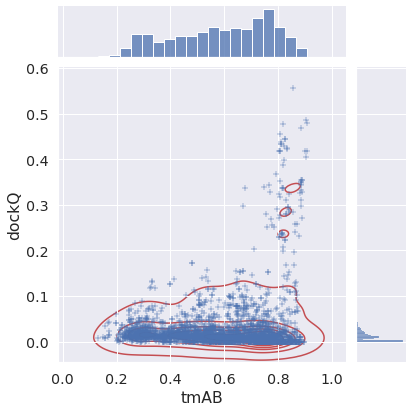

In [64]:
newdf=df.loc[df.JHparams.isin(Rosettaset)]
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,12)})
sns.set(font_scale=1.3)
jplot=sns.jointplot(data=newdf, x="tmAB", y="dockQ",kind="scatter",marker="+",legend=False)
jplot.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6,legend=False)
#sns_plot=sns.jointplot(data=newdf, x=k, y=l,hue="good",kind="kde")
#jplot.title="Good models: "
#jplot.savefig("jointplot-good-models-TPR-PPV.png",bbox_inches="tight",dpi=600)


In [41]:
# PPV vs recall (TPR)
#good["TPR"]=good.contacts/good["Native Contacts"]
good[["name","JHparams","MCC","contacts","F1","PPV","numcorrect","Native Contacts","TPR"]].sort_values("numcorrect")

name      JHparams    MCC  contacts     F1    PPV  \
86     1v5i_u1_A-1v5i_u2_A            N3  0.125         2  0.059  0.500   
31069  1v5i_u1_A-1v5i_u2_A            N3  0.125         2  0.059  0.500   
25440  4txo_u1_A-4txo_u2_A  N1-minprob25  0.456         5  0.345  1.000   
36107  1ay7_u1_A-1ay7_u2_A        rbh-jh  0.199        50  0.189  0.140   
29561  3a8i_u2_A-3a8i_u1_A      N3-cov90  0.251        31  0.250  0.226   
...                    ...           ...    ...       ...    ...    ...   
31315  4gmj_u1_A-4gmj_u2_A            N3  0.683       287  0.645  0.484   
30449  4gmj_u1_A-4gmj_u2_A  N3-minprob25  0.683       287  0.645  0.484   
30881  4gmj_u1_A-4gmj_u2_A        N3-pdb  0.683       287  0.645  0.484   
29687  4gmj_u2_A-4gmj_u1_A      N3-cov90  0.669       325  0.625  0.458   
29686  4gmj_u1_A-4gmj_u2_A      N3-cov90  0.679       324  0.638  0.472   

       numcorrect  Native Contacts       TPR  
86          1.000              272  0.003676  
31069       1.000              272  0.003676  
25440       5.000              247  0.020243  
36107       7.000              204  0.034314  
29561       7.006              211  0.033204  
...           ...              ...       ...  
31315     138.908              239  0.581205  
30449     138.908              239  0.581205  
30881     138.908              239  0.581205  
29687     148.850              239  0.622803  
29686     152.928              239  0.639866  

[156 rows x 9 columns]

In [46]:
df=pd.read_csv("~/Downloads/summary.csv",sep=",",dtype=dtype_dic,warn_bad_lines=True,error_bad_lines=False)
#df=df.dropna()
df["code"]=df["name"].str[:4]
df["CODE"]=df["code"]
df["params"]=df["JHparams"]

In [47]:
df.loc[df.taxa.isna()]["JHparams"].unique().isna()

AttributeError: 'numpy.ndarray' object has no attribute 'isna'

In [48]:
tempdf=df.loc[df.JHparams=="N3-pdb"].dropna(axis=0, how="any")
tempdf.loc[tempdf.JHparams=="N3-pdb"]

name JHparams  lenA  lenB   msa    msaA    msaB  cdhit  \
29935  1ay7_u1_A-1ay7_u2_A   N3-pdb    97    90  1060    1485    2034    280   
29936  1ay7_u2_A-1ay7_u1_A   N3-pdb    90    97  1060    2034    1485    283   
29937  1b27_u1_A-1b27_u2_A   N3-pdb   109    90   733    1484    2034    221   
29938  1b27_u2_A-1b27_u1_A   N3-pdb    90   109   733    2034    1484    230   
29939  1bdj_u1_A-1bdj_u2_A   N3-pdb   129   118  5651  349880   23051   2604   
...                    ...      ...   ...   ...   ...     ...     ...    ...   
30364  5cec_u2_A-5cec_u1_A   N3-pdb   191   403  1274  309307   30621    770   
30365  5cra_u1_A-5cra_u2_A   N3-pdb   193    77     1      11   38383      1   
30366  5cra_u2_A-5cra_u1_A   N3-pdb    77   193     1   38383      11      1   
30367  5eg3_u1_A-5eg3_u2_A   N3-pdb   303   105   421  565997   25926    101   
30368  5eg3_u2_A-5eg3_u1_A   N3-pdb   105   303   421   25926  565997    103   

       dockQ   fnat  ...  shortF1MODEL  medF1MODEL  longF1MODEL  rank  pcd  \
29935  0.400  0.333  ...           0.0       0.375        0.967     1 -1.0   
29936  0.329  0.306  ...           0.0       0.571        0.929     2 -1.0   
29937  0.254  0.080  ...           0.0       0.364        0.981     1 -1.0   
29938  0.220  0.120  ...           0.0       0.308        0.961     2 -1.0   
29939  0.000  0.000  ...           0.0       0.000        0.000     1 -1.0   
...      ...    ...  ...           ...         ...          ...   ...  ...   
30364  0.003  0.000  ...           0.0       0.000        0.000     2 -1.0   
30365  0.046  0.018  ...           0.0       0.000        0.000     1 -1.0   
30366  0.088  0.036  ...           0.0       0.000        0.059     2 -1.0   
30367  0.000  0.000  ...           0.0       0.000        0.000     1 -1.0   
30368  0.000  0.000  ...           0.0       0.000        0.000     2 -1.0   

       mmd  taxa  code  CODE  params  
29935 -1.0     2  1ay7  1ay7  N3-pdb  
29936 -1.0     2  1ay7  1ay7  N3-pdb  
29937 -1.0     2  1b27  1b27  N3-pdb  
29938 -1.0     2  1b27  1b27  N3-pdb  
29939 -1.0     2  1bdj  1bdj  N3-pdb  
...    ...   ...   ...   ...     ...  
30364 -1.0     2  5cec  5cec  N3-pdb  
30365 -1.0     0  5cra  5cra  N3-pdb  
30366 -1.0     0  5cra  5cra  N3-pdb  
30367 -1.0     1  5eg3  5eg3  N3-pdb  
30368 -1.0     1  5eg3  5eg3  N3-pdb  

[434 rows x 86 columns]

In [49]:
for key in tempdf.keys():
    is_error = pd.to_numeric(tempdf[key], errors='coerce').isna()
    print (key,len(tempdf[is_error]))

name 434
JHparams 434
lenA 0
lenB 0
msa 0
msaA 0
msaB 0
cdhit 0
dockQ 0
fnat 0
iRMS 0
LRMS 0
fnonnat 0
mm 0
tmA 0
tmB 0
long 0
med 0
longPPV 0
medPPV 0
longA 0
medA 0
longPPVA 0
medPPVA 0
longB 0
medB 0
longPPVB 0
medPPVB 0
short 0
shortPPV 0
shortA 0
shortPPVA 0
shortB 0
shortPPVB 0
shortpdb 0
medpdb 0
longpdb 0
avprob 0
longMODEL 0
medMODEL 0
longPPVMODEL 0
medPPVMODEL 0
longAMODEL 0
medAMODEL 0
longPPVAMODEL 0
medPPVAMODEL 0
longBMODEL 0
medBMODEL 0
longPPVBMODEL 0
medPPVBMODEL 0
shortMODEL 0
shortPPVMODEL 0
shortAMODEL 0
shortPPVAMODEL 0
shortBMODEL 0
shortPPVBMODEL 0
shortpdbMODEL 0
medpdbMODEL 0
longpdbMODEL 0
avprobMODEL 0
evalue 0
seqid 0
hhprob 0
hhevalue 0
hhscore 0
PconsDock 0
MMdock 0
shortMCC 0
medMCC 0
longMCC 0
shortF1 0
medF1 0
longF1 0
shortMCCMODEL 0
medMCCMODEL 0
longMCCMODEL 0
shortF1MODEL 0
medF1MODEL 0
longF1MODEL 0
rank 0
pcd 0
mmd 0
taxa 0
code 434
CODE 434
params 434


In [50]:
#df=pd.read_csv("~/Downloads/summary.csv",sep=",")


In [51]:
df["rank"]

0        1
1        2
2        1
3        2
4        1
        ..
37910    5
37911    6
37912    7
37913    8
37914    9
Name: rank, Length: 37915, dtype: int64

In [52]:
# Make summary csv
summary_df=pd.DataFrame(columns=["params","Num","<dockQ>","<TM>","Num-first","<dockQ-first>","<TM-first>","Num-best","<dockQ-best>","<TM-best>"])
cutoff=0.23
df_max=df.groupby(["JHparams","code"]).max()
for i in df.params.unique():
    df_all=df.loc[(df.params==i)]
    df_best=df_max.loc[(df_max.params==i)]
    df_first=df.loc[(df.params==i)&(df["rank"]==1)]
    #print (df_first)
    df_temp=pd.DataFrame(
         [[i,len(df_first.loc[df_first.dockQ>cutoff]),np.mean(df_first.dockQ),np.mean(df_first.tmAB),
         len(df_first.loc[df_first.dockQ>cutoff]),np.mean(df_first.dockQ),np.mean(df_first.tmAB),
         len(df_first.loc[df_first.dockQ>cutoff]),np.mean(df_first.dockQ),np.mean(df_first.tmAB)]],
         columns=["params","Num","<dockQ>","<TM>","Num-first","<dockQ-first>","<TM-first>","Num-best","<dockQ-best>","<TM-best>"]
        )
    #print (df_temp)
    #pd.concat([summary_df,df_temp],ignore_index=True)
    summary_df=summary_df.append(df_temp)
    
summary_df

AttributeError: 'DataFrame' object has no attribute 'tmAB'

In [53]:
is_error = pd.to_numeric(df["JHparams"], errors='coerce').isna()
df[is_error]

name      JHparams  lenA  lenB   msa    msaA   msaB  \
0      1ay7_u1_A-1ay7_u2_A  -N 3 --cpu 8    97    90  1060    1485   2034   
1      1ay7_u2_A-1ay7_u1_A  -N 3 --cpu 8    90    97  1060    2034   1485   
2      1b27_u1_A-1b27_u2_A  -N 3 --cpu 8   109    90   733    1484   2034   
3      1b27_u2_A-1b27_u1_A  -N 3 --cpu 8    90   109   733    2034   1484   
4      1bdj_u1_A-1bdj_u2_A  -N 3 --cpu 8   129   118  5651  349880  23051   
...                    ...           ...   ...   ...   ...     ...    ...   
37910  4xhu_u1_A-4xhu_u2_A        TMdock   352    95   410    8381    307   
37911  4xhu_u1_A-4xhu_u2_A        TMdock   352    95   410    8381    307   
37912  4xhu_u1_A-4xhu_u2_A        TMdock   352    95   410    8381    307   
37913  4xhu_u1_A-4xhu_u2_A        TMdock   352    95   410    8381    307   
37914  4xhu_u1_A-4xhu_u2_A        TMdock   352    95   410    8381    307   

       cdhit  dockQ   fnat  ...  shortF1MODEL  medF1MODEL  longF1MODEL  rank  \
0       1026  0.281  0.167  ...           0.0       0.400        0.984     1   
1        989  0.239  0.250  ...           0.0       0.471        0.971     2   
2        654  0.223  0.120  ...           0.0       0.462        0.990     1   
3        656  0.229  0.160  ...           0.0       0.429        0.980     2   
4       5071  0.000  0.000  ...           0.0       0.000        0.000     1   
...      ...    ...    ...  ...           ...         ...          ...   ...   
37910     66  0.000  0.000  ...           0.0       0.000        0.000     5   
37911     66  0.009  0.000  ...           0.0       0.000        0.040     6   
37912     66  0.000  0.000  ...           0.0       0.000        0.000     7   
37913     66  0.011  0.000  ...           0.0       0.000        0.000     8   
37914     66  0.003  0.000  ...           0.0       0.000        0.000     9   

            pcd       mmd  taxa  code  CODE        params  
0      0.798400  0.826483     2  1ay7  1ay7  -N 3 --cpu 8  
1      0.837400  0.823468     2  1ay7  1ay7  -N 3 --cpu 8  
2      0.841200  0.827082     2  1b27  1b27  -N 3 --cpu 8  
3      0.765400  0.817868     2  1b27  1b27  -N 3 --cpu 8  
4      0.000000  0.431493     2  1bdj  1bdj  -N 3 --cpu 8  
...         ...       ...   ...   ...   ...           ...  
37910  0.000200  0.709884     1  4xhu  4xhu        TMdock  
37911  0.001111  0.709884     1  4xhu  4xhu        TMdock  
37912  0.000100  0.709884     1  4xhu  4xhu        TMdock  
37913  0.001000  0.709884     1  4xhu  4xhu        TMdock  
37914  0.000500  0.709884     1  4xhu  4xhu        TMdock  

[37915 rows x 86 columns]

In [54]:
df=df.replace({
        '-N 1 -E 1.e-10 --cpu 8 ':'N1',
        '-N 3 --cpu 8':'N3',
        '-N 5 --cpu 8':'N5'
        })


In [55]:
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
for d in df.keys():
    print (d,is_numeric_dtype(df[d]))

    
    

name False
JHparams False
lenA True
lenB True
msa True
msaA True
msaB True
cdhit True
dockQ True
fnat True
iRMS True
LRMS True
fnonnat True
mm True
tmA True
tmB True
long True
med True
longPPV True
medPPV True
longA True
medA True
longPPVA True
medPPVA True
longB True
medB True
longPPVB True
medPPVB True
short True
shortPPV True
shortA True
shortPPVA True
shortB True
shortPPVB True
shortpdb True
medpdb True
longpdb True
avprob True
longMODEL True
medMODEL True
longPPVMODEL True
medPPVMODEL True
longAMODEL True
medAMODEL True
longPPVAMODEL True
medPPVAMODEL True
longBMODEL True
medBMODEL True
longPPVBMODEL True
medPPVBMODEL True
shortMODEL True
shortPPVMODEL True
shortAMODEL True
shortPPVAMODEL True
shortBMODEL True
shortPPVBMODEL True
shortpdbMODEL True
medpdbMODEL True
longpdbMODEL True
avprobMODEL True
evalue True
seqid True
hhprob True
hhevalue True
hhscore True
PconsDock True
MMdock True
shortMCC True
medMCC True
longMCC True
shortF1 True
medF1 True
longF1 True
shortMCCMODEL True
m

In [143]:
# Define some sets
#Rosettaset=['N1','N3','N5', 'N1-cov90','N3-cov90',"N1-minprob25","N3-minprob25"] 
Rosettaset=['N1','N3', 'N1-cov90','N3-cov90','N1-cov50','N3-cov50',"N1-minprob25","N3-minprob25"] 
RosettasetA=['N1', 'N3-cov90',"N1-minprob25","N1-cov50","N5"] 
RosettasetB=['N3', 'N1-cov90',"N3-minprob25","N3-cov50"] 
comboset=Rosettaset+['N1-N3-multimerged', 'N1-N3-new', 'N1-N3-cov90', 'N1-N3-cov-nocov']+["trRosetta"] 
dockingset=["gramm","gramm-contact","TMdock-double","trRosetta"]
grammset=["gramm","gramm-contact","gramm-trmodels","gramm-raptorx","gramm-score","gramm-score2"]

allset=list(set(Rosettaset+comboset+dockingset+grammset))



In [57]:
# Testing strategoes for selecting trRosetta
r=re.compile("^PDB|^pdb|^TMd|gramm")
datasets=df.JHparams.unique()
notRosettaset=list(filter(r.match, datasets))
#notRosettaset

In [58]:

RosettasetAll=list(df.loc[~df.JHparams.isin(notRosettaset)]["JHparams"].unique())
RosettasetAll

['N3',
 'confold-contacts',
 'confold-merged',
 'confold-npz',
 'confold-pdb',
 'confold-plm',
 'confold',
 'confold-raptorx',
 'N1-all',
 '-N 1 -E 1.e-2 ',
 'N1-cov50',
 'N1-cov90-minprob25',
 'N1-cov90',
 'N1-minprob25',
 'N1-N3-cov90',
 'N1-N3-cov-nocov',
 'N1-N3-new',
 'N1-N3-multimerged',
 'N1',
 'N3-all',
 'N3-bact',
 'N3-cov50',
 'N3-cov90-minprob25',
 'N3-cov90',
 'N3-merged',
 'N3-minprob25',
 'N3-pdb',
 'N5',
 'RaptorX',
 'rbh-jh',
 'rbh']

In [59]:
r=re.compile("^N")
datasets=df.JHparams.unique()
RosettasetAll=list(filter(r.match, datasets))
print (RosettasetAll)


['N3', 'N1-all', 'N1-cov50', 'N1-cov90-minprob25', 'N1-cov90', 'N1-minprob25', 'N1-N3-cov90', 'N1-N3-cov-nocov', 'N1-N3-new', 'N1-N3-multimerged', 'N1', 'N3-all', 'N3-bact', 'N3-cov50', 'N3-cov90-minprob25', 'N3-cov90', 'N3-merged', 'N3-minprob25', 'N3-pdb', 'N5']


In [60]:

RosettasetN=['N1','N3'] # ,'N5'
RosettasetNc=['N1-cov90','N3-cov90']
RosettasetNm=['N1-minprob25','N3-minprob25']
RosettasetN1=['N1', 'N1-cov90',"N1-minprob25"]
RosettasetN3=['N3', 'N3-cov90',"N3-minprob25"]
Rosettaset=['N1','N3', 'N1-cov90','N3-cov90',"N1-minprob25","N3-minprob25"] 

In [61]:
sets={"Rosettaset":"N3","comboset":"N1-N3-cov-nocov","dockingset":"gramm","grammset":"gramm","All":"gramm"}
setdata={"Rosettaset":Rosettaset,"comboset":comboset,"dockingset":dockingset,"grammset":grammset,"All":allset}

#sets={"Rosettaset":Rosettaset, "RosettasetN":RosettasetN,
#      "RosettasetNc":RosettasetNc, "RosettasetNm":RosettasetNm,
#      "RosettasetN1":RosettasetN1, "RosettasetN3":RosettasetN3,
#      "RosettasetAll":RosettasetAll}

methods=["PconsDock", "MMdock","mmd","pcd"] # "dockQ", 

    


In [88]:
L=len(df.loc[df.JHparams.isin(Rosettaset)]["cdhit"])
X1=len(df.loc[(df.JHparams.isin(Rosettaset))&(df.cdhit<1.01)]["cdhit"])
X10=len(df.loc[(df.JHparams.isin(Rosettaset))&(df.cdhit<10.01)]["cdhit"])
X50=len(df.loc[(df.JHparams.isin(Rosettaset))&(df.cdhit<50.01)]["cdhit"])
X100=len(df.loc[(df.JHparams.isin(Rosettaset))&(df.cdhit<100.01)]["cdhit"])
X1000=len(df.loc[(df.JHparams.isin(Rosettaset))&(df.cdhit<1000.01)]["cdhit"])

U1=len(df.loc[(df.JHparams.isin(Rosettaset))&(df.cdhit<1.01)]["code"].unique())
U10=len(df.loc[(df.JHparams.isin(Rosettaset))&(df.cdhit<10.01)]["code"].unique())
U50=len(df.loc[(df.JHparams.isin(Rosettaset))&(df.cdhit<50.01)]["code"].unique())
U100=len(df.loc[(df.JHparams.isin(Rosettaset))&(df.cdhit<100.01)]["code"].unique())
U1000=len(df.loc[(df.JHparams.isin(Rosettaset))&(df.cdhit<1000.01)]["code"].unique())

M1=len(df.loc[(df.JHparams.isin(Rosettaset))&(df.cdhit<1.01)&(df["dockQ"]>0.23)]["code"].unique())
M10=len(df.loc[(df.JHparams.isin(Rosettaset))&(df.cdhit<10.01)&(df["dockQ"]>0.23)]["code"].unique())
M50=len(df.loc[(df.JHparams.isin(Rosettaset))&(df.cdhit<50.01)&(df["dockQ"]>0.23)]["code"].unique())
M50=len(df.loc[(df.JHparams.isin(Rosettaset))&(df.cdhit<50.01)&(df["dockQ"]>0.23)]["code"].unique())
M100=len(df.loc[(df.JHparams.isin(Rosettaset))&(df.cdhit<100.01)&(df["dockQ"]>0.23)]["code"].unique())
M1000=len(df.loc[(df.JHparams.isin(Rosettaset))&(df.cdhit<1000.01)&(df["dockQ"]>0.23)]["code"].unique())

print ("1",U1,X1,X1/L,M1)
print ("10",U10,X10,X10/L,M10)
print ("50",U50,X50,X50/L,M50)
print ("100",U100,X100,X100/L,M100)
print ("1000",U1000,X1000,X1000/L,M1000)

df.loc[(df.JHparams.isin(Rosettaset))&(df.cdhit<100.01)&(df["dockQ"]>0.23)][["dockQ","code","cdhit","tmAB"]]


1 52 412 0.16056118472330475 0
10 79 625 0.24356975837879968 0
50 128 958 0.37334372564302415 1
100 160 1295 0.504676539360873 3
1000 211 2295 0.8943881527669525 10


dockQ  code  cdhit      tmAB
24175  0.297  2o3b     71  0.669925
24634  0.252  2zae     53  0.758670
24635  0.328  2zae     53  0.768765
26762  0.338  2o3b     75  0.677050
26792  0.255  2zae     53  0.778420
26793  0.268  2zae     53  0.773190
28984  0.252  3k1i     36  0.786495

In [18]:
Rosettaset=RosettasetAll

In [91]:
df.loc[(df.JHparams.isin(Rosettaset))&(df["dockQ"]>0.23)][["dockQ","code","cdhit","tmAB"]].sort_values(["tmAB"])




dockQ  code  cdhit      tmAB
24175  0.297  2o3b     71  0.669925
26762  0.338  2o3b     75  0.677050
26923  0.340  4gmj    423  0.746985
28884  0.281  2d5r    197  0.756340
24634  0.252  2zae     53  0.758670
...      ...   ...    ...       ...
24587  0.418  2hqs   1986  0.900290
26744  0.486  2hqs   1986  0.902625
24157  0.405  2hqs   1857  0.903220
24158  0.418  2hqs   1862  0.907205
26745  0.480  2hqs   1989  0.907610

[64 rows x 4 columns]

In [93]:
df.loc[(df.JHparams.isin(Rosettaset))&(df.cdhit<1.01)][["dockQ","code","cdhit","tmAB"]].sort_values(["tmAB"])


dockQ  code  cdhit      tmAB
24325  0.007  4cu4      1  0.129740
26911  0.009  4cu4      1  0.148590
320    0.008  4cu4      1  0.157990
24324  0.033  4cu4      1  0.158095
29060  0.011  4cu4      1  0.167090
...      ...   ...    ...       ...
28991  0.024  3l4q      1  0.546745
24255  0.015  3l4q      1  0.548585
26843  0.029  3l4q      1  0.549705
27019  0.053  5cra      1  0.552035
429    0.061  5cra      1  0.562420

[412 rows x 4 columns]

In [95]:
df.loc[(df.JHparams.isin(Rosettaset))&(df.dockQ>0.23)][["dockQ","code","cdhit","tmAB","long","longMCC"]].sort_values(["long"])

dockQ  code  cdhit      tmAB  long  longMCC
86     0.336  1v5i   1642  0.818890     2    0.125
24826  0.285  4txo   1598  0.840105     5    0.456
28946  0.259  3a8i   5421  0.870110    31    0.484
28947  0.231  3a8i   5421  0.877400    31    0.251
24634  0.252  2zae     53  0.758670    35    0.682
...      ...   ...    ...       ...   ...      ...
24763  0.323  4gmj    423  0.803535   310    0.657
29072  0.439  4gmj    461  0.810420   324    0.679
29073  0.429  4gmj    477  0.822475   325    0.669
24764  0.292  4gmj    429  0.796040   330    0.610
26924  0.318  4gmj    429  0.809265   330    0.610

[64 rows x 6 columns]

In [97]:
mean=np.mean(df.loc[(df.JHparams.isin(Rosettaset))&(df.dockQ>0.23)]["long"])
std=np.std(df.loc[(df.JHparams.isin(Rosettaset))&(df.dockQ>0.23)]["long"])

print (mean,std)

125.484375 96.62604983056782


In [102]:
X=len(df.loc[(df.JHparams.isin(Rosettaset))&(df.long<1)])
Y=len(df.loc[(df.JHparams.isin(Rosettaset))])
print (X/Y)


0.5085736554949337


In [108]:
df.loc[(df.JHparams.isin(Rosettaset))&(df.long<10)][["long","dockQ"]].sort_values(["dockQ"])


long  dockQ
4         0  0.000
26728     0  0.000
26736     0  0.000
26737     0  0.000
26748     0  0.000
...     ...    ...
27000     0  0.156
24546     0  0.168
24545     0  0.208
24826     5  0.285
86        2  0.336

[1609 rows x 2 columns]

In [114]:
df.loc[(df.JHparams.isin(Rosettaset))&(df.dockQ>0.23)][["longMCC","long","dockQ"]].sort_values(["longMCC"])


longMCC  long  dockQ
86       0.125     2  0.336
28947    0.251    31  0.231
28897    0.402    57  0.344
24826    0.456     5  0.285
28946    0.484    31  0.259
...        ...   ...    ...
0        0.884    61  0.281
28942    0.902    53  0.477
28943    0.919    71  0.418
201      0.936   107  0.433
29706    0.936   107  0.455

[64 rows x 3 columns]

In [139]:
len(df.loc[(df.JHparams.isin(Rosettaset))&(df.hhprob>50)&(df.long>1000)]["code"].unique())

9

In [138]:
len(df.loc[(df.JHparams.isin(Rosettaset))&(df.hhprob>90)&(df.long>1000)][["longMCC","long","hhprob","seqid","dockQ","code"]].sort_values(["seqid"]))

59

In [130]:
df.loc[(df.JHparams.isin(Rosettaset))&(df.long>1000)][["longMCC","long","hhprob","seqid","dockQ","code"]].sort_values(["dockQ"])

longMCC  long  hhprob   seqid  dockQ  code
24398   -0.004  2329   100.0  59.011  0.009  4rix
26985   -0.004  1796   100.0  59.011  0.010  4rix
24823   -0.004  1796   100.0  59.011  0.010  4rix
24397   -0.005  2385   100.0  59.011  0.010  4rix
24362   -0.001  1122    99.8  39.669  0.010  4lsx
29132   -0.005  5146   100.0  59.011  0.010  4rix
395     -0.007  5154   100.0  59.011  0.010  4rix
394      0.004  5115   100.0  59.011  0.010  4rix
29133   -0.007  5154   100.0  59.011  0.010  4rix
29897    0.004  5115   100.0  59.011  0.011  4rix
24822   -0.004  1851   100.0  59.011  0.011  4rix
26984   -0.004  1851   100.0  59.011  0.011  4rix
29898   -0.007  5154   100.0  59.011  0.011  4rix
29098    0.023  6942    99.9  39.669  0.014  4lsx
28880   -0.005  1123   100.0  27.368  0.017  2c2v
29645   -0.005  1123   100.0  27.368  0.018  2c2v
26949   -0.001  1032    99.8  39.669  0.020  4lsx
359      0.024  7250    99.7  39.669  0.024  4lsx
29862    0.024  7250    99.7  39.669  0.024  4lsx
29861    0.023  6942    99.5  39.669  0.026  4lsx
137     -0.005  1123   100.0  27.368  0.026  2c2v
24286    0.226  2201   100.0  28.729  0.031  3qlu
26874    0.229  2690   100.0  29.282  0.036  3qlu
282      0.214  7918   100.0  28.729  0.043  3qlu
358      0.023  6942    99.5  39.669  0.043  4lsx
24287    0.227  2181   100.0  29.282  0.045  3qlu
29787    0.214  7918   100.0  28.729  0.048  3qlu
29024    0.209  7390   100.0  29.282  0.050  3qlu
29023    0.210  7282   100.0  28.729  0.050  3qlu
26873    0.231  2697   100.0  28.729  0.052  3qlu
283      0.213  7921   100.0  29.282  0.060  3qlu
29788    0.213  7921   100.0  29.282  0.067  3qlu
29918    0.268  2363   100.0  43.448  0.068  4xs0
28969    0.308  1571    99.9  35.455  0.071  3f1p
29733    0.323  1354    99.9  35.455  0.072  3f1p
29792    0.273  1270    99.5  41.379  0.073  3rnk
24716    0.229  2690   100.0  29.282  0.074  3qlu
286      0.275  1180    99.4  41.379  0.077  3rnk
29791    0.275  1180    99.4  41.379  0.077  3rnk
29152    0.267  2212   100.0  43.448  0.077  4xs0
287      0.273  1270    99.5  41.379  0.078  3rnk
28970    0.309  1543    99.9  35.455  0.080  3f1p
29054    0.291  1376    99.9  28.169  0.081  4c6t
29734    0.325  1257    99.9  35.455  0.081  3f1p
29559    0.256  2188    99.9  39.286  0.082  1jk9
29055    0.313  1343    99.9  30.263  0.087  4c6t
48       0.256  2077    99.9  39.286  0.087  1jk9
29153    0.267  2203   100.0  43.448  0.088  4xs0
49       0.256  2188    99.9  39.286  0.091  1jk9
29558    0.256  2077    99.9  39.286  0.092  1jk9
315      0.284  1548    99.9  30.263  0.095  4c6t
414      0.260  2555   100.0  43.448  0.095  4xs0
314      0.269  1585    99.9  28.169  0.097  4c6t
29817    0.269  1585    99.9  28.169  0.097  4c6t
228      0.323  1354    99.9  35.455  0.100  3f1p
29818    0.284  1548    99.9  30.263  0.105  4c6t
229      0.325  1257    99.9  35.455  0.116  3f1p
29917    0.260  2555   100.0  43.448  0.120  4xs0
415      0.268  2363   100.0  43.448  0.126  4xs0

In [140]:
df2=df.loc[df.params.isin(Rosettaset)].copy()
is_numeric_dtype(df["PconsDock"])


True

In [141]:
# We have to think which ones to use..
df2=df.loc[df.params.isin(Rosettaset)].copy()
df2.JHparams="trRosetta"
df2.params="trRosetta"

columns=df2.keys()
df3=pd.DataFrame(columns=columns)

# we need tpo update the ranks
df2.sort_values("PconsDock",axis=0,inplace=True)
#print(df2.keys())
for code in df2["code"].unique():
    #print (code)
    tempdf=df2.loc[df2["code"]==code]
    #print (tempdf[["rank","PconsDock"]])
    #print (tempdf["PconsDock"].rank(method="first"))
    tempdf["rank"]=tempdf["PconsDock"].rank(method="first",ascending=False)
    df3=pd.concat([df3,tempdf],ignore_index=True)
df=pd.concat([df,df3], ignore_index=True,sort=False)




<ipython-input-141-0888030b1376>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf["rank"]=tempdf["PconsDock"].rank(method="first",ascending=False)


In [142]:
df["tmAB"]=df[["tmA","tmB"]].mean(axis=1)
df["msaAB"]=df[["msaA","msaB"]].mean(axis=1)
df["tmAB_max"]=df[["tmA","tmB"]].max(axis=1)
df["msaAB_max"]=df[["msaA","msaB"]].max(axis=1)
df["tmAB_min"]=df[["tmA","tmB"]].min(axis=1)
df["msaAB_min"]=df[["msaA","msaB"]].min(axis=1)
df["numcorrect"]=df["longPPV"]*df["long"]
df["len"]=df["lenA"]+df["lenB"]


In [143]:
codes=df.code.unique()
df_mean=df.groupby(["JHparams","code"]).mean()
df_max=df.groupby(["JHparams","code"]).max()
df_min=df.groupby(["JHparams","code"]).min()
df_first=df.loc[df["rank"]==1]
#df_max["JHparams"]=df_max["params"]
#df_min["JHparams"]=df_min["params"]
#df_mean["JHparams"]=df_mean["params"]


In [144]:
cutoff=0.23
goodmodels=df.loc[(df.dockQ>cutoff)&(df.params.isin(Rosettaset+comboset))].code.unique()
good_df=df.loc[(df.code.isin(goodmodels))&(df.params.isin(Rosettaset))] #.reset_index()
#df.dockQ.dtypes


In [145]:
print(goodmodels,len(goodmodels))

['1ay7' '1gpw' '1v5i' '2zae' '4gmj' '1vrs' '2hqs' '2o3b' '4bmp' '4txo'
 '2hrk' '1b27' '4pw9' '4xhu' '2d5r' '3a8i' '3k1i'] 17


In [146]:
df["log-cdhit"]=df.cdhit.apply(lambda x:(np.log10(x+0.1)))
df["log-avprob"]=df.avprob.apply(lambda x:(np.log10(x+0.1)))
df["log-hhprob"]=df.hhprob.apply(lambda x:(np.log10(x+0.1)))
df["log-long"]=df.long.apply(lambda x:(np.log10(x+0.1)))
df["log-med"]=df.med.apply(lambda x:(np.log10(x+0.1)))
df["log-short"]=df.short.apply(lambda x:(np.log10(x+0.1)))
df["log-hhevalue"]=df.hhevalue.apply(lambda x:(np.log10(x+0.1)))
#keys=[ 'cdhit',"msa", 'long',"med", 'shortpdb', 'hhprob',"seqid","log-hhevalue",'PconsDock', 'MMdock', 'longMCC', 'longF1', 'medMCC', 'medF1', 'shortMCC', 'shortF1', 'tmAB', 'len',"log-cdhit","log-long","pcd","mmd","shortpdb","medpdb","longpdb","avprob","log-avprob","log-hhprob","shortMODEL","medMODEL","longMODEL","shortPPVMODEL","medPPVMODEL","longPPVMODEL"] #
skipkeys=set(["name","params","JHparams","code","CODE","rank"])
allkeys=set(df.keys())
keys=allkeys-skipkeys
#selset=["trRosetta"]
sets2={"trRosetta":["trRosetta"],"Rosettaset":Rosettaset} #,"N-test":["N1","N3"] # ,"N5"



In [147]:
#tempdf["log-cdhit"]
df["log-cdhit"].astype(int).unique()

array([3, 2, 1, 0])

In [148]:
# Some violin plots for life
cutoff=0.23
goodmodels=list(df.loc[(df.dockQ>cutoff)&(df.params.isin(Rosettaset))].code.unique())
good_df=df.loc[(df.code.isin(goodmodels))&(df.params.isin(Rosettaset))] #.reset_index()
df["good"]=df["code"].isin(goodmodels)
#df


In [149]:
df.loc[(df.dockQ>cutoff),"goodmodel"]=True
df.loc[(df.dockQ<=cutoff),"goodmodel"]=False
#df[(df.dockQ>cutoff)]
df.goodmodel

0         True
1         True
2        False
3        False
4        False
         ...  
40476     True
40477     True
40478     True
40479     True
40480     True
Name: goodmodel, Length: 40481, dtype: object

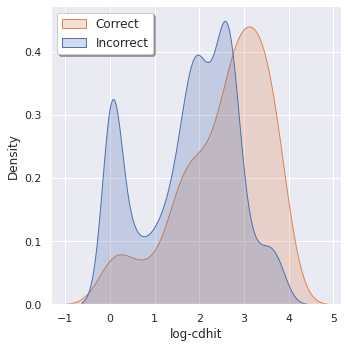

In [212]:
newdf=df.loc[df.params.isin(Rosettaset)]
s=sns.displot(newdf,x="log-cdhit",hue="good",multiple="layer",kind="kde",common_norm=False,fill=True,legend=False)
plt.legend( loc='upper left',
              fontsize = 12, 
           #bbox_to_anchor= (.9, 1), 
               title="",
           labels=["Correct","Incorrect"],
               title_fontsize = 18, 
               shadow = True, 
               facecolor = 'white')

In [213]:
tempdf=df.loc[(df.params.isin(Rosettaset)&(df["rank"]==1))]
newdf=df.loc[(df.params.isin(Rosettaset))]


In [157]:
newdf.longpdb

0        204
1        204
2        273
3        273
4        115
        ... 
29930    583
29931    266
29932    241
29933     21
29934     13
Name: longpdb, Length: 2566, dtype: object

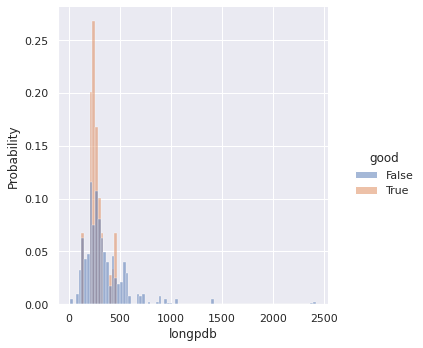

In [162]:
sns_plot=sns.displot(newdf,x="longpdb",hue="good",multiple="layer",kind="hist",common_norm=False,fill=True,stat="probability")


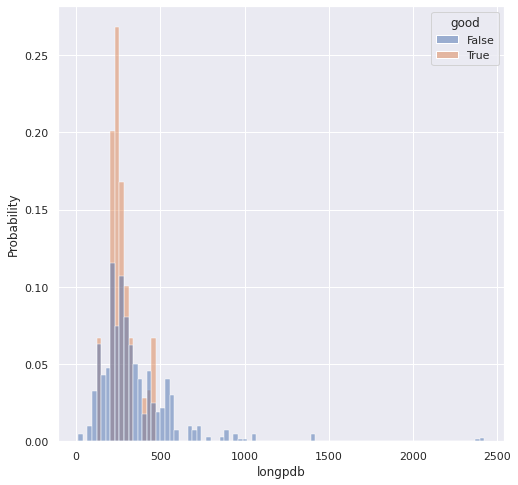

In [161]:
sns_plot=sns.histplot(newdf,x="longpdb",hue="good",multiple="layer",stat="probability",common_norm=False,fill=True)

In [42]:
df["log-Meff-int"]=df["log-cdhit"].astype(int)

<ipython-input-50-9b4131bcf288>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf[k+"R"]=newdf.taxa.apply(lambda x:(x+-0.1+0.2*(np.random.rand())))


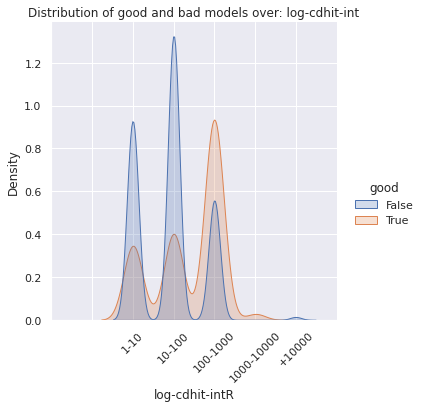

In [50]:
dic_t={"taxa":["","","Mixed","Eukaryotes","Bacteria","Archaea","Viruses"],
      "log-cdhit-int":["","","1-10","10-100","100-1000","1000-10000","+10000"],
      "log-long-int":["","","1-10","10-100","100-1000","1000-10000","10000+","0-1"],
                }
newdf=df.loc[df.params.isin(Rosettaset)]
for k in ["log-cdhit-int"]:
    newdf[k+"R"]=newdf.taxa.apply(lambda x:(x+-0.1+0.2*(np.random.rand())))
    sns_plot=sns.displot(newdf,x=k+"R",hue="good",multiple="layer",kind="kde",common_norm=False,fill=True)
    sns_plot.set(title='Distribution of good and bad models over: '+k)
    sns_plot.set(xlim=(-2,5))
    if k in dic_t:
        sns_plot.set_xticklabels(dic_t[k],rotation=45)
    sns_plot.savefig("displot-good-bad-"+k+".png",bbox_inches="tight")


In [30]:
tempdf["taxaR"]=tempdf.taxa.apply(lambda x:(x+-0.1+0.2*(np.random.rand())))
tempdf["taxaR"]


<ipython-input-30-12f82eb8fc95>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf["taxaR"]=tempdf.taxa.apply(lambda x:(x+-0.1+0.2*(np.random.rand())))


0        2.025351
2        1.931489
4        2.098009
6        0.945428
8        2.061315
           ...   
29592    0.933876
29594    0.093234
29596    1.912114
29598   -0.012905
29600    0.968603
Name: taxaR, Length: 3658, dtype: float64

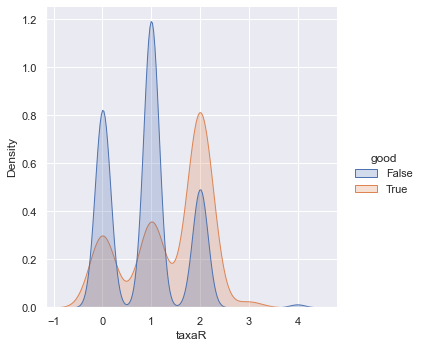

In [44]:
sns_plot=sns.displot(tempdf,x="taxaR",hue="good",multiple="layer",kind="kde",common_norm=False,fill=True)


In [34]:
tempdf["log-Meff"]

        

KeyError: 'log-Meff'

In [27]:
#sets2={"Rosettaset":Rosettaset}
sets2={"trRosetta":["trRosetta"],"Rosettaset":Rosettaset,"N-test":["N1","N3","N5"]}

In [28]:
# List why some models are good and some not


newdf=df.loc[(df.params.isin(Rosettaset)) & (df.cdhit>30) & (df.long>10)  & (df.long<300)  & (df.tmAB>0.6) & (df.pcd>0.5)].sort_values(["pcd"],ascending=False)

print (len(newdf.code.unique()),len(newdf.loc[newdf.dockQ>cutoff]["code"].unique()))

21 13


In [29]:
def get_numexamples(newdf):
    d["num"]=[len(newdf.code.unique())]
    d["numgood"]=[len(newdf.loc[newdf.dockQ>cutoff]["code"].unique())]
    d["nummod"]=[len(newdf.code)]
    d["numgoodmod"]=[len(newdf.loc[newdf.dockQ>cutoff]["code"])]
    d["frac"]=[d["numgood"][0]/(d["num"][0]+0.0001)]
    d["fracmod"]=[d["numgoodmod"][0]/(d["nummod"][0]+0.0001)]
    return(d)


In [30]:
df_filter=pd.DataFrame()
tiny=1.e-20
for k in keys:
    dfmax=df.loc[(df.JHparams.isin(Rosettaset))][k].max()+tiny
    dfmin=df.loc[(df.JHparams.isin(Rosettaset))][k].min()-tiny
    dfdiff=(dfmax-dfmin)/4
    for dmin in np.arange(dfmin,dfmax,dfdiff):
        for dmax in np.arange(dmin+dfdiff,dfmax,dfdiff):
            #print (k,dmin,dmax)
            newdf=df.loc[(df.JHparams.isin(Rosettaset)&(df[k]<=dmax)&(df[k]>=dmin))]
            d={k+"_min":[dmin],k+"_max":[dmax]}
            d.update(get_numexamples(newdf))
            df_filter=df_filter.append(pd.DataFrame.from_dict(d),ignore_index=True)
    
df_filter
                



longpdbMODEL_min  longpdbMODEL_max  num  numgood  nummod  numgoodmod  \
0       -1.000000e-20          18293.75  221       16    4722         112   
1       -1.000000e-20          36587.50  222       16    4733         112   
2       -1.000000e-20          54881.25  222       16    4735         112   
3        1.829375e+04          36587.50    4        0      11           0   
4        1.829375e+04          54881.25    4        0      13           0   
..                ...               ...  ...      ...     ...         ...   
588               NaN               NaN   34        0     249           0   
589               NaN               NaN   67        0     492           0   
590               NaN               NaN   15        0      56           0   
591               NaN               NaN   54        0     299           0   
592               NaN               NaN   48        0     271           0   

         frac   fracmod  hhevalue_min  hhevalue_max  ...  evalue_min  \
0    0.072398  0.023719           NaN           NaN  ...         NaN   
1    0.072072  0.023664           NaN           NaN  ...         NaN   
2    0.072072  0.023654           NaN           NaN  ...         NaN   
3    0.000000  0.000000           NaN           NaN  ...         NaN   
4    0.000000  0.000000           NaN           NaN  ...         NaN   
..        ...       ...           ...           ...  ...         ...   
588  0.000000  0.000000           NaN           NaN  ...         NaN   
589  0.000000  0.000000           NaN           NaN  ...         NaN   
590  0.000000  0.000000           NaN           NaN  ...         NaN   
591  0.000000  0.000000           NaN           NaN  ...         NaN   
592  0.000000  0.000000           NaN           NaN  ...         NaN   

     evalue_max  shortF1MODEL_min  shortF1MODEL_max  log-avprob_min  \
0           NaN               NaN               NaN             NaN   
1           NaN               NaN               NaN             NaN   
2           NaN               NaN               NaN             NaN   
3           NaN               NaN               NaN             NaN   
4           NaN               NaN               NaN             NaN   
..          ...               ...               ...             ...   
588         NaN               NaN               NaN             NaN   
589         NaN               NaN               NaN             NaN   
590         NaN               NaN               NaN             NaN   
591         NaN               NaN               NaN             NaN   
592         NaN               NaN               NaN             NaN   

     log-avprob_max  tmAB_min_min  tmAB_min_max   medPPVA_min  medPPVA_max  
0               NaN           NaN           NaN           NaN          NaN  
1               NaN           NaN           NaN           NaN          NaN  
2               NaN           NaN           NaN           NaN          NaN  
3               NaN           NaN           NaN           NaN          NaN  
4               NaN           NaN           NaN           NaN          NaN  
..              ...           ...           ...           ...          ...  
588             NaN           NaN           NaN -1.000000e-20         0.50  
589             NaN           NaN           NaN -1.000000e-20         0.75  
590             NaN           NaN           NaN  2.500000e-01         0.50  
591             NaN           NaN           NaN  2.500000e-01         0.75  
592             NaN           NaN           NaN  5.000000e-01         0.75  

[593 rows x 194 columns]

In [97]:
#df_filter

In [61]:
tempdf=df.loc[df.params.isin(Rosettaset)]
d

5927 5927


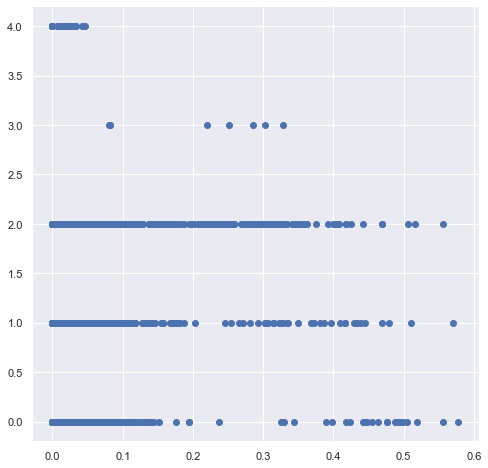

In [67]:
pos=tempdf.taxa.to_list()
data=tempdf.dockQ.to_list()
print (len(pos),len(data))
#ax.violinplot(pos,data, points=80, vert=True, widths=0.7,
#            showmeans=True, showextrema=True, showmedians=False)    
#plt.scatter(data,pos)

<ipython-input-81-77382618adb9>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["Mixed","Eukaryotes","Bacteria","Archaea","Viruses"])


{'bodies': [<matplotlib.collections.PolyCollection at 0x14e4ff4c0>,
 'cmeans': <matplotlib.collections.LineCollection at 0x14e4fa190>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x14e507670>,
 'cmins': <matplotlib.collections.LineCollection at 0x14e507a30>,
 'cbars': <matplotlib.collections.LineCollection at 0x14e4fa130>}

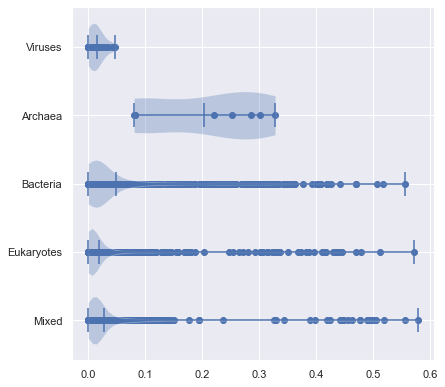

In [81]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
k="dockQ"
plt.scatter(tempdf.dockQ,tempdf.taxa)
#done[d]=0
#average[d]=all_df.loc[(all_df.params==d)]["tmA"].mean()
#length[d]=len(all_df.loc[(all_df.params==d)]["tmA"]
tempdata=tempdf.loc[(tempdf.taxa==d)][k].to_list()
i=0
data=[]
keys=[]
pos=[]
for d in sorted(tempdf.taxa.unique(),reverse=False):
    tempdata=tempdf.loc[tempdf.taxa==d][k].to_list()
    if len(tempdata)>0:
        pos+=[i]
        keys+=[d]
        data+=[tempdata]
        i+=1
         
ax.set_yticklabels(["Mixed","Eukaryotes","Bacteria","Archaea","Viruses"])
ax.set_yticks(pos)

#print (data,pos)
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
            showmeans=True, showextrema=True, showmedians=False)    
  


In [38]:
# plotting some more plots for N3
sets=["N1","N3","N5"]
tempdf=df.loc[df.params.isin(sets)]




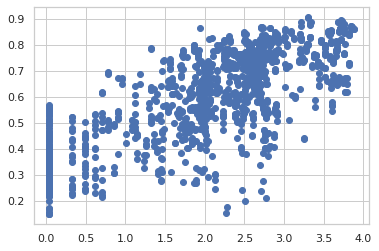

In [39]:
plt.scatter(tempdf["log-cdhit"],tempdf.tmAB)

In [180]:
df["log-Meff"]=df.cdhit.apply(lambda x:(np.log10(x+0.1)))

Text(0.5, 30.49999999999995, 'Meff')

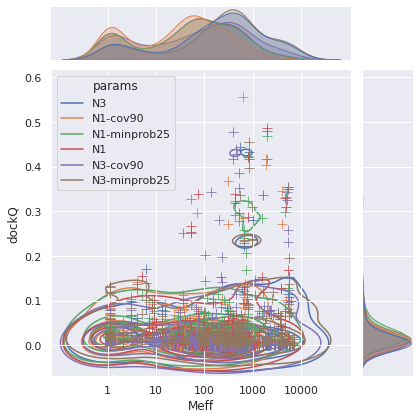

In [189]:
k="dockQ"
tempdf=df.loc[df.params.isin(Rosettaset)]
jplot=sns.jointplot(data=tempdf, x="log-Meff", y=k,hue="params",kind="scatter",marker="+",s=100)
jplot.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
#sns_plot=sns.jointplot(data=newdf, x=k, y=l,hue="good",kind="kde")
#jplot.savefig("Meff-"+k+"-"+s+".png",bbox_inches="tight",dpi=600)
jplot.ax_joint.set_xticks([0,1,2,3,4])
jplot.ax_joint.set_xticklabels([1,10,100,1000,10000])
jplot.ax_joint.set_xlabel("Meff")


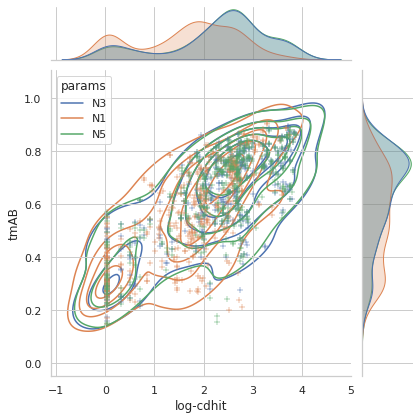

In [43]:
jplot=sns.jointplot(data=tempdf, x="log-cdhit", y="tmAB",hue="params",kind="scatter",marker="+")
jplot.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
#sns_plot=sns.jointplot(data=newdf, x=k, y=l,hue="good",kind="kde")
jplot.savefig("cdhit-tm.png",bbox_inches="tight")


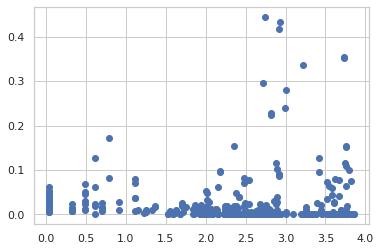

In [35]:
plt.scatter(tempdf["log-cdhit"],tempdf.dockQ)


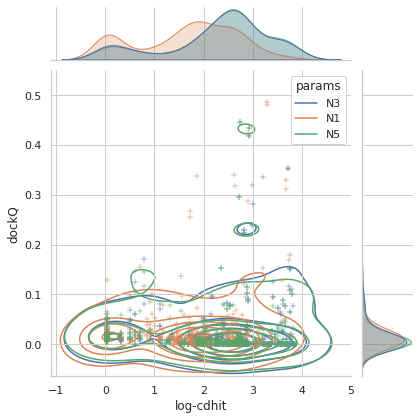

In [44]:
jplot=sns.jointplot(data=tempdf, x="log-cdhit", y="dockQ",hue="params",kind="scatter",marker="+")
jplot.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
#sns_plot=sns.jointplot(data=newdf, x=k, y=l,hue="good",kind="kde")
jplot.savefig("cdhit-dockQ.png",bbox_inches="tight")


In [116]:
# Check some special targets

# 1ay7  / 1 vrs (good)
# 3qlu (artefact)
Rosettaset=['N1','N3',"N5", 'N1-cov90','N3-cov90', 'N1-cov50','N3-cov50',"N1-minprob25","N3-minprob25"] 
Rosettaset=["N1","N3","N1-cov90",'N3-cov90']
newdf=df.loc[df.params.isin(Rosettaset)]

              


In [117]:
goodcodes=newdf.loc[newdf.dockQ>cutoff]["CODE"].unique()
goodcodes

array(['1ay7', '1gpw', '1v5i', '2zae', '4gmj', '1vrs', '2hqs', '2o3b',
       '2d5r', '2hrk', '3a8i', '3k1i'], dtype=object)

3.2962482429489337 0.0 1vrs
3.296028636106722 0.001 1vrs
2.792461731346951 0.556 1vrs
2.792461731346951 0.285 1vrs
2.906388921152831 0.423 1vrs
2.906388921152831 0.28800000000000003 1vrs
2.2332500095411003 0.008 1vrs
2.2332500095411003 0.07200000000000001 1vrs
3.2962482429489337 0.0 1vrs
3.296028636106722 0.001 1vrs
2.792461731346951 0.556 1vrs
2.792461731346951 0.285 1vrs
2.906388921152831 0.423 1vrs
2.906388921152831 0.28800000000000003 1vrs
2.2332500095411003 0.008 1vrs
2.2332500095411003 0.07200000000000001 1vrs
3.2962482429489337 0.0 1vrs
3.296028636106722 0.001 1vrs
2.792461731346951 0.556 1vrs
2.792461731346951 0.285 1vrs
2.906388921152831 0.423 1vrs
2.906388921152831 0.28800000000000003 1vrs
2.2332500095411003 0.008 1vrs
2.2332500095411003 0.07200000000000001 1vrs
3.2962482429489337 0.0 1vrs
3.296028636106722 0.001 1vrs
2.792461731346951 0.556 1vrs
2.792461731346951 0.285 1vrs
2.906388921152831 0.423 1vrs
2.906388921152831 0.28800000000000003 1vrs
2.2332500095411003 0.008 1vrs


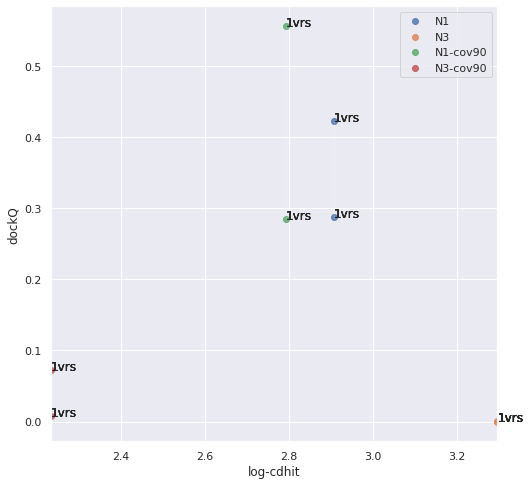

In [121]:
#fig,ax=plt.subplots(figsize=(6.5, 6.5))
#tempdf=newdf.loc[newdf.CODE=="1ay7"]
#sns.set(rc={'figure.figsize':(24,24)})
#jplot=sns.jointplot(data=tempdf, x="log-cdhit", y="dockQ",hue="params",kind="scatter",marker="+",s=1000)
#jplot.fig.set_figwidth(8)
#jplot.fig.set_figheight(8)
#goodcodes=["1vrs"]
tempdf=newdf.loc[newdf.CODE.isin(goodcodes)]

for k in Rosettaset:
    jplot=sns.regplot(data=tempdf.loc[tempdf.params==k], x="log-cdhit", y="dockQ",label=str(k))
    #jplot.fig.figure(figsize=(15,8))
    #jplot.set_figwidth(8)
    #jplot.set_figheight(8)
    
    for i, row in tempdf.iterrows():
        #print (i,row)
        sstr=str(row["CODE"])
        print (row["log-cdhit"],row["dockQ"],sstr)
        jplot.text(row["log-cdhit"],row["dockQ"],sstr)

jplot.legend()

#jplot.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
#sns_plot=sns.jointplot(data=newdf, x=k, y=l,hue="good",kind="kde")
#jplot.savefig("good-examples-cdhit-dockQ.png",bbox_inches="tight")


In [ ]:
# Get best dockQ scores.
tempdf=newdf.loc[newdf.CODE.isin(goodcodes)]
for s in Rosettaset:
    s=


In [98]:
#df_filter=pd.DataFrame()
m=0
M=0
P=0

for c in [0,30,100,250,500]:
    for lm in [0,30,50,100]:
        for ln in [999999,300,100]:
            for t in [0,0.5]:
                for h in [0,1,50,100]:
                    for p in [0,0.5]:
                        for l in [0,0.2]:
                            d={"cdhit_min":[c],"long_min":[lm],"long_max":[ln],"tmAB_min":[t],"pcd_min":[p],"PconsDock_min":[P],"longPPVMODEL_min":[l],"mmd_min":[m],"MMdock_min":[M],"hhprob_max":[h]}
                            #print(d)
                            newdf=df.loc[
                                (df.JHparams.isin(Rosettaset))&
                            (df.cdhit>=d["cdhit_min"][0]) &
                            (df.long>=d["long_min"][0]) &
                            (df.long<=d["long_max"][0]) &
                            (df.tmAB>=d["tmAB_min"][0]) &
                            (df.pcd>=d["pcd_min"][0]) &
                            (df.PconsDock>=d["PconsDock_min"][0]) &
                            (df.mmd>=d["mmd_min"][0]) &
                            (df.MMdock>=d["MMdock_min"][0]) &
                            (df.hhprob<=d["hhprob_max"][0]) &
                            (df.longPPVMODEL>=d["longPPVMODEL_min"][0])
                        ].sort_values(["pcd"],ascending=False)
                            d.update(get_numexamples(newdf))
                            df_filter=df_filter.append(pd.DataFrame.from_dict(d),ignore_index=True)
#print (df_filter)                            



#newdf=df.loc
df_filter

longA_min  longA_max  num  numgood  nummod  numgoodmod      frac  \
0          16.0     2833.5  221       14    3184          67  0.063348   
1          16.0     5651.0  221       15    3433          82  0.067873   
2          16.0     8468.5  221       15    3447          82  0.067873   
3        2833.5     5651.0   39        5     249          15  0.128205   
4        2833.5     8468.5   42        5     263          15  0.119047   
...         ...        ...  ...      ...     ...         ...       ...   
2490        NaN        NaN    0        0       0           0  0.000000   
2491        NaN        NaN    0        0       0           0  0.000000   
2492        NaN        NaN    0        0       0           0  0.000000   
2493        NaN        NaN    0        0       0           0  0.000000   
2494        NaN        NaN    0        0       0           0  0.000000   

       fracmod  log-cdhit_min  log-cdhit_max  ...  hhprob_min  hhprob_max  \
0     0.021043            NaN            NaN  ...         NaN         NaN   
1     0.023886            NaN            NaN  ...         NaN         NaN   
2     0.023789            NaN            NaN  ...         NaN         NaN   
3     0.060241            NaN            NaN  ...         NaN         NaN   
4     0.057034            NaN            NaN  ...         NaN         NaN   
...        ...            ...            ...  ...         ...         ...   
2490  0.000000            NaN            NaN  ...         NaN        50.0   
2491  0.000000            NaN            NaN  ...         NaN       100.0   
2492  0.000000            NaN            NaN  ...         NaN       100.0   
2493  0.000000            NaN            NaN  ...         NaN       100.0   
2494  0.000000            NaN            NaN  ...         NaN       100.0   

      msaA_min  msaA_max  tmB_min  tmB_max  medPPVA_min  medPPVA_max  \
0          NaN       NaN      NaN      NaN          NaN          NaN   
1          NaN       NaN      NaN      NaN          NaN          NaN   
2          NaN       NaN      NaN      NaN          NaN          NaN   
3          NaN       NaN      NaN      NaN          NaN          NaN   
4          NaN       NaN      NaN      NaN          NaN          NaN   
...        ...       ...      ...      ...          ...          ...   
2490       NaN       NaN      NaN      NaN          NaN          NaN   
2491       NaN       NaN      NaN      NaN          NaN          NaN   
2492       NaN       NaN      NaN      NaN          NaN          NaN   
2493       NaN       NaN      NaN      NaN          NaN          NaN   
2494       NaN       NaN      NaN      NaN          NaN          NaN   

      msaAB_max_min  msaAB_max_max  
0               NaN            NaN  
1               NaN            NaN  
2               NaN            NaN  
3               NaN            NaN  
4               NaN            NaN  
...             ...            ...  
2490            NaN            NaN  
2491            NaN            NaN  
2492            NaN            NaN  
2493            NaN            NaN  
2494            NaN            NaN  

[2495 rows x 190 columns]

In [99]:
df_filter.to_csv("fraction.csv")


In [100]:
d={}
newdf=df.loc[(df.JHparams.isin(Rosettaset))&(df.cdhit>30)&(df.med<10)&(df.long>1)
             &(df.mmd>0.6)&(df.longMCCMODEL>0.5)
] #&(df.med<5)&(df.long>1)]
get_numexamples(newdf)

{'num': [39],
 'numgood': [15],
 'nummod': [181],
 'numgoodmod': [73],
 'frac': [0.38461439842461936],
 'fracmod': [0.40331469430127387]}

In [101]:
newdf.JHparams.unique()

array(['N3', 'N1-cov50', 'N1-cov90-minprob25', 'N1-cov90', 'N1-minprob25',
       'N3-cov50', 'N3-cov90-minprob25', 'N3-cov90', 'N3-minprob25', 'N5'],
      dtype=object)

In [102]:
df.loc[(df.JHparams.isin(Rosettaset))&(df.cdhit>30)&(df.dockQ>0.2)&(df["hhprob"]>99)]

name  JHparams lenA lenB  msa   msaA  msaB cdhit  dockQ  \
12936  2hrk_u1_A-2hrk_u2_A  N3-cov90  181  121  192  18121  4930   141  0.344   

        fnat  ...  tmAB_min  msaAB_min  numcorrect  len  log-cdhit  \
12936  0.239  ...   0.73979     4930.0      19.024  302   7.140574   

       log-avprob log-hhprob  log-long  log-hhevalue  good  
12936   -2.244685   6.640968  5.860466      6.640968  True  

[1 rows x 99 columns]

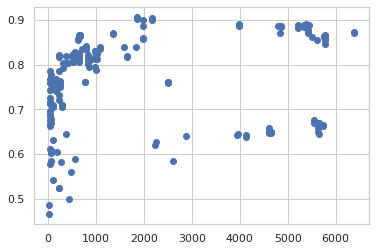

In [103]:
#newdf=df.loc[(df.JHparams.isin(Rosettaset))]
#plt.scatter(newdf.hhprob,newdf.short)
plt.scatter(newdf.cdhit,newdf.tmAB)

In [104]:
len(df.loc[df.JHparams.isin(Rosettaset)])

3462

In [105]:
newdf=df.loc[(df.JHparams=="N3")]
get_numexamples(newdf)


{'num': [221],
 'numgood': [5],
 'nummod': [440],
 'numgoodmod': [9],
 'frac': [0.022624424151844274],
 'fracmod': [0.02045454080578618]}

ValueError: x and y must be the same size

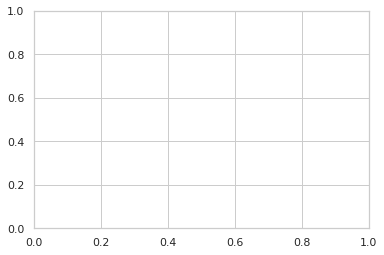

ValueError: x and y must be the same size

In [106]:
newdf=df.loc[(df.JHparams.isin(["N3","confold"]))]
newdf_max=newdf.groupby(["JHparams","code"]).max()
newdf_max
plt.scatter(newdf_max[newdf_max.params=="N3"].dockQ,newdf_max[newdf_max.params=="confold"].dockQ)
plt.xticks(rotation=90)


In [107]:
newdf=df.loc[(df.JHparams=="confold")]
get_numexamples(newdf)


{'num': [219],
 'numgood': [4],
 'nummod': [2185],
 'numgoodmod': [32],
 'frac': [0.018264831842542538],
 'fracmod': [0.014645308254219301]}

(-1.0, 231.0)

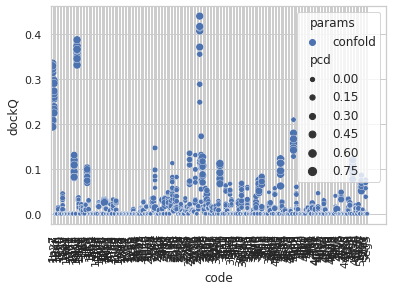

In [108]:

f=sns.scatterplot(data=newdf, x="code", y="dockQ", hue="params", size="pcd") 
plt.xticks(rotation=90)
f.set_xlim(-1,len(newdf.code.unique())+12)


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

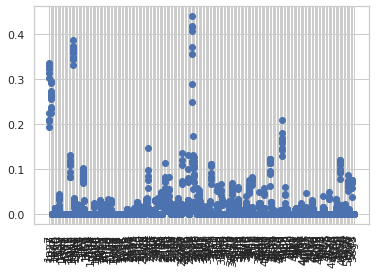

In [109]:
plt.scatter(newdf.code,newdf.dockQ,label=df.params)
plt.xticks(rotation=90)

In [110]:
 for s in sets2.keys():
    tempdf=df.loc[(df.params.isin(sets2[s])&(df["rank"]==1))]
    for key in keys:
        #print (s,key)
        #codes=df_max.loc[df_max.params.isin(selset)]["CODE"].unique()
        f, ax = plt.subplots(figsize=(6.5, 6.5))
        plt.scatter(tempdf[key],tempdf.dockQ)
        #ax.legend(loc = 'upper left')
        ax.set(ylim=[0,1.0])
        ax.set(xlim=[0,1.0])
        ax.set_title("Comparison "+key+" vs dockQ in "+s)
        ax.set_ylabel("dockQ")
        ax.set_xlabel(key)
        #print (tempdf[[key,"dockQ","params"]])
        plt.savefig("scatter-"+key+"-"+s+"-dockQ.png",bbox_inches="tight")
        plt.close(fig="all")

        #sns_plot=sns.jointplot(data=tempdf,x=key,y="dockQ",hue="params",kind="hist") # reg crashes
        #sns_plot.savefig("joint-"+key+"-"+s+"-dockQ.png",bbox_inches="tight")
        #plt.close(fig="all")
        # MSA should be log



In [111]:
import sklearn
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
#rom sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LassoLars

#from sklearn.linear_model import TweedieRegressor

from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


In [112]:
reg = LinearRegression()
#reg=RandomForestClassifier(n_estimators=10)
#reg=LassoLars(alpha=.1)
#reg = TweedieRegressor(power=1, alpha=0.5, link='log')
#reg=TheilSenRegressor(random_state=42)
#reg=RANSACRegressor(random_state=42)
#reg=HuberRegressor()


In [113]:
methods=["PconsDock", "MMdock","pcd","mmd"] # "dockQ", 
X=df.loc[df.params.isin(Rosettaset)][methods]
Y=df.loc[df.params.isin(Rosettaset)]["dockQ"]


In [114]:
correct=Y>0.23
fpr, tpr, threshold = metrics.roc_curve(correct, pred)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = ': AUC = %0.2f' % roc_auc)



ValueError: Found input variables with inconsistent numbers of samples: [3462, 749]

In [115]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.linear_model import Perceptron

In [116]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
degree=3


In [117]:
mets=[ 'PconsDock', 'pcd','MMdock','mmd', 'cdhit', 'long', 'tmAB', 'longPPVMODEL','log-avprob','hhprob','log-cdhit','log-hhprob']

In [118]:

modset=["PconsDock", "MMdock","pcd","mmd"]
predset=["log-hhprob","log-avprob","long"]
seqset=["cdhit"]
tmset=["tmAB","longPPVMODEL"]
cheatset=["longF1","longMCC","shortF1","medF1"]
methodsets={"modelinfo":modset,
            "seqinfo":seqset,
            "structinfo":tmset,
            "predinfo":predset,
            "cheatinfo":cheatset,
            "m+s-info":modset+seqset,
            "m+t-info":modset+tmset,
            "m+s+t-info":modset+seqset+tmset,
            "m+s+p-info":modset+seqset+predset,
            "m+s+p+t-info":modset+seqset+predset+tmset,
            "s+p-info":seqset+predset,
            "m+p-info":modset+seqset,
            "s+p+t-info":seqset+predset+tmset,
            "m+p+t-info":modset+seqset+tmset,
            "pcd":["pcd"],
            "mmd":["mmd"],
            "mmd+cdhit":["mmd","cdhit"],
            "PconsDock":["PconsDock"],
            "MMdock":["MMdock"],
            "mets":mets,
            "dockQ":["dockQ"]
}


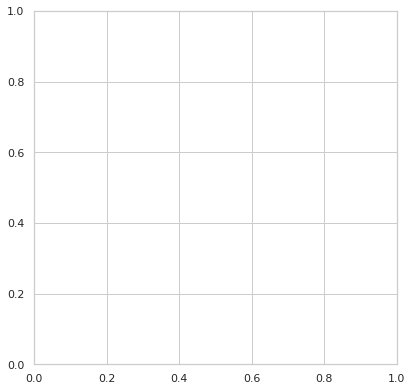

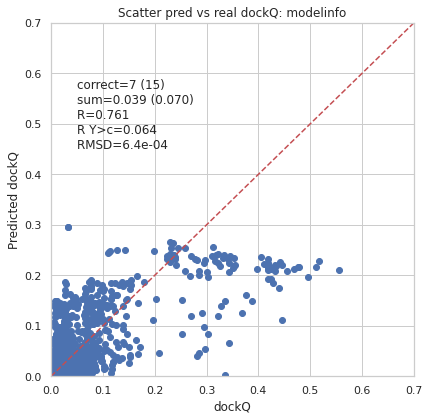

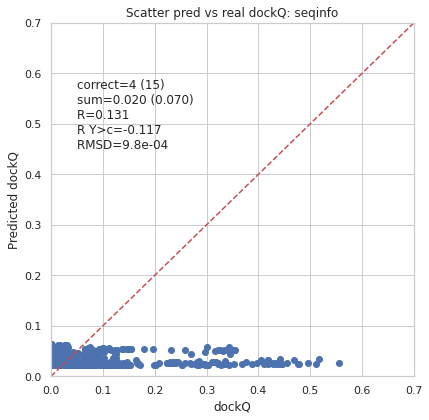

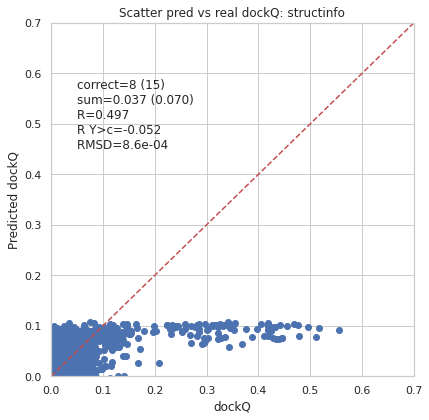

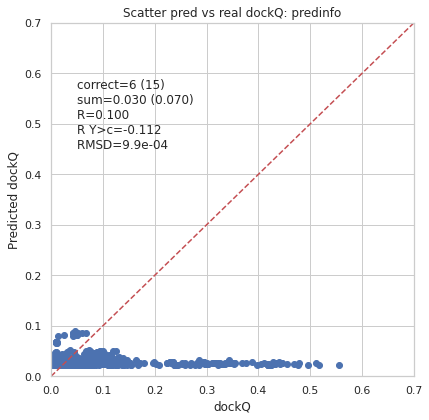

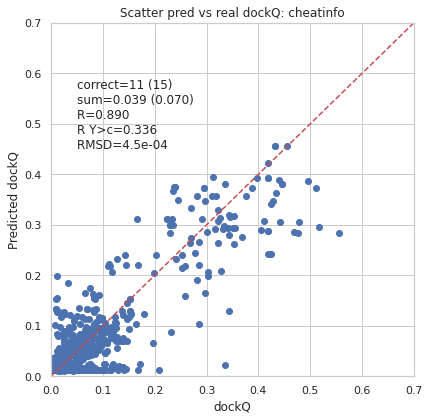

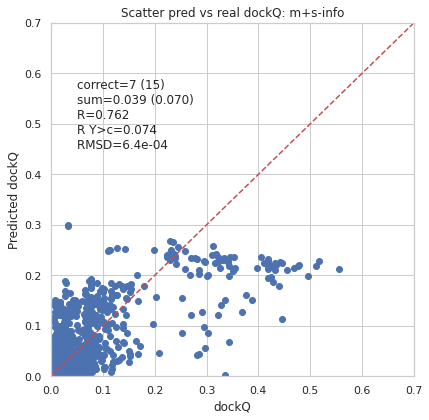

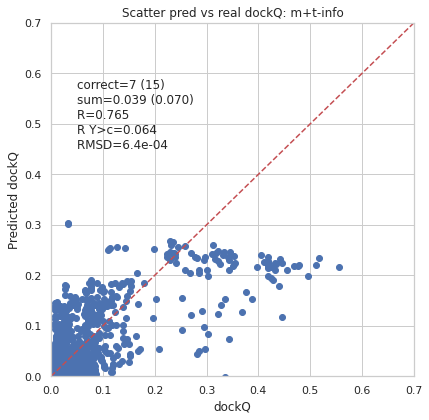

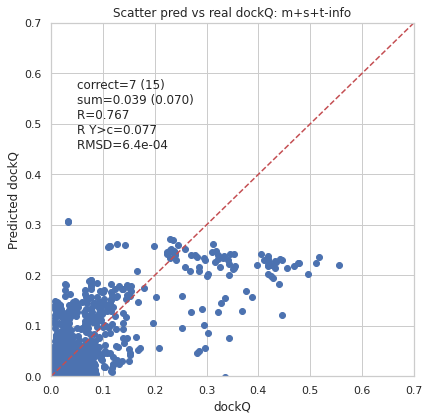

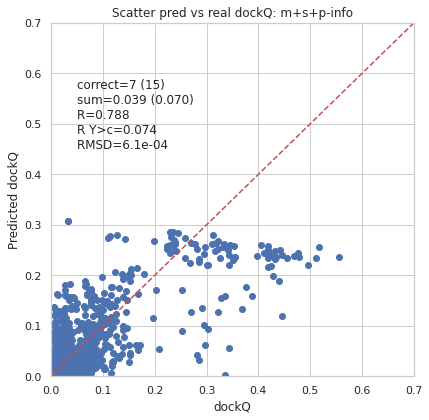

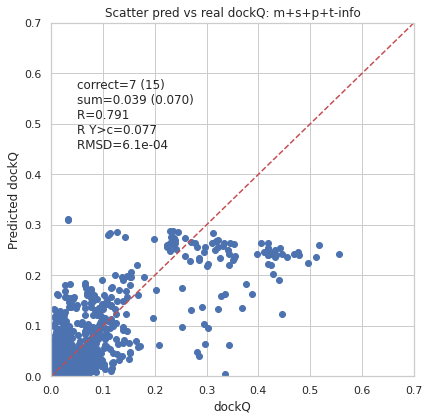

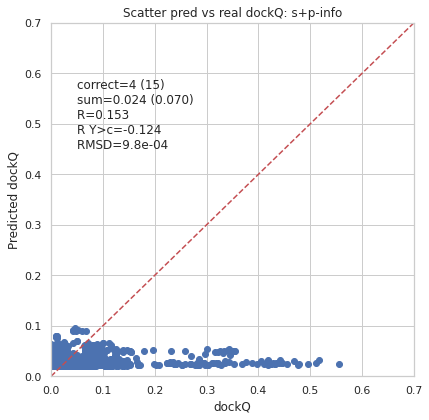

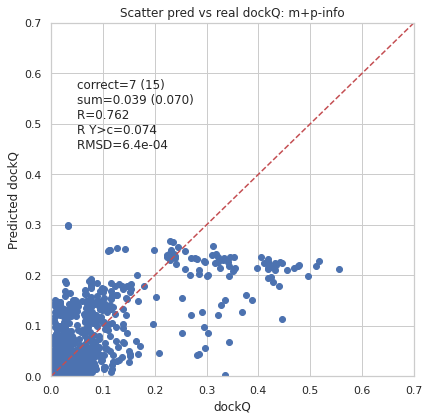

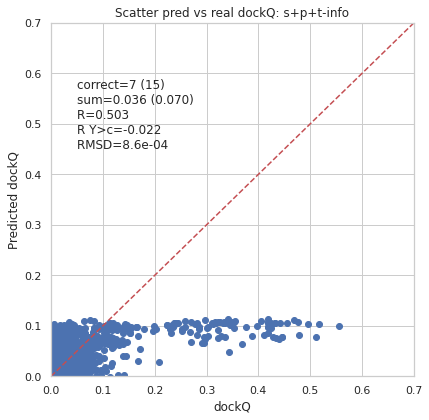

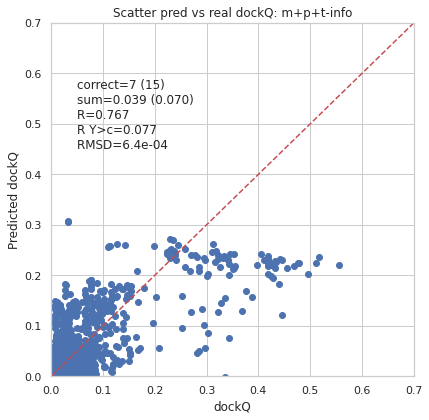

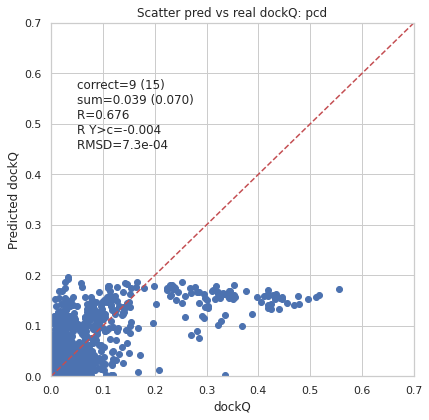

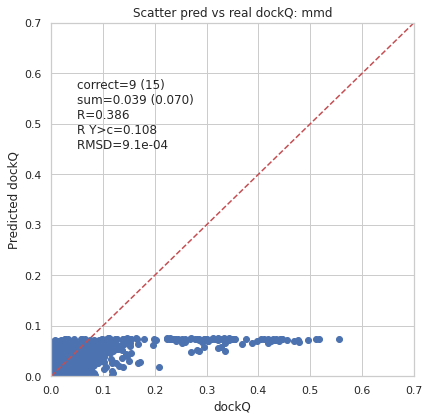

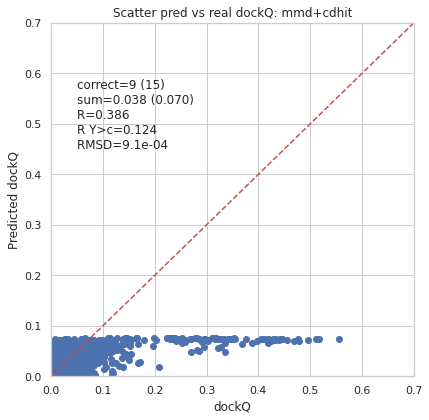

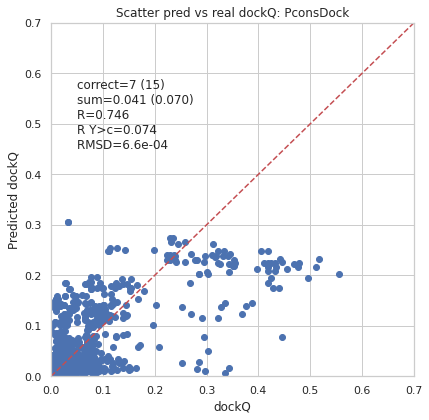

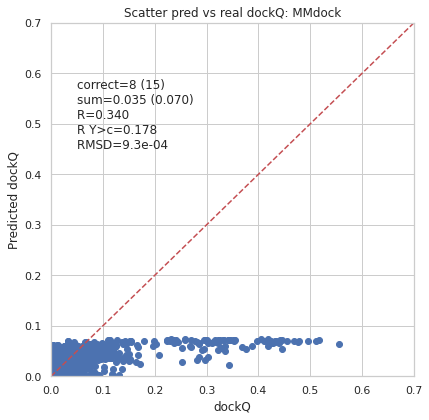

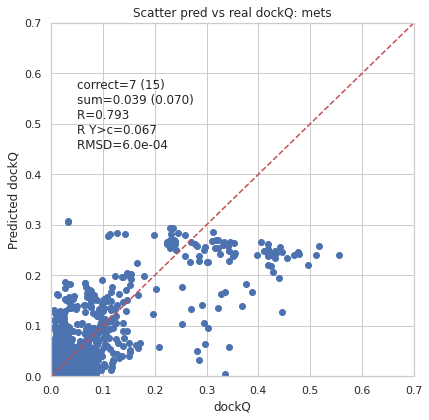

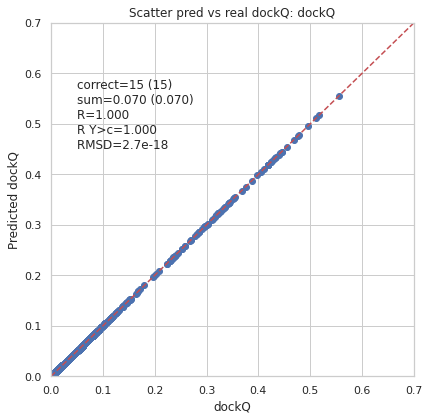

In [119]:

fig,ax=plt.subplots(figsize=(6.5, 6.5))
for m in methodsets.keys():
    X=df.loc[df.params.isin(Rosettaset)][methodsets[m]]
    Y=df.loc[df.params.isin(Rosettaset)]["dockQ"]
    reg.fit(X,Y)
    pred=reg.predict(X)
    err=mean_squared_error(pred,Y)
    fig2,ax2=plt.subplots(figsize=(6.5, 6.5))
    ax2.scatter(Y,pred)
    #fig2.show()
    correct=Y>cutoff
    fpr, tpr, threshold = metrics.roc_curve(correct, pred)
    roc_auc = metrics.auc(fpr, tpr)

    corr=np.corrcoef(Y,pred)

    Y2=Y.loc[Y>corrcut]
    X2=X.loc[Y>corrcut]
    pred2=reg.predict(X2)
    corr2=np.corrcoef(Y2,pred2)

    tempdf=df.loc[df.params.isin(Rosettaset)].copy()
    tempdf["pred"]=pred
    bestdf=tempdf.loc[df.params.isin(Rosettaset)].sort_values("pred",ascending=False).groupby(["code"]).first()
    #print (bestdf[["CODE","dockQ","mmd"]])
    c=sum(bestdf["dockQ"]>cutoff)
    s=sum(bestdf["dockQ"])/len(bestdf)
    topdf=tempdf.loc[df.params.isin(Rosettaset)].sort_values("dockQ",ascending=False).groupby(["code"]).first()
    #print (topdf[["CODE","dockQ","mmd"]])
    t=sum(topdf["dockQ"]>cutoff)
    S=sum(topdf["dockQ"])/len(topdf)
    #print ("test",sum(correct),corr[0,1],c,t,s,S)
    rmsd=np.sqrt(np.sum((pred-Y)**2))/len(pred)
    textstr = '\n'.join((
        r'correct=%d (%d)' % (c,t ),
        r'sum=%.3f (%.3f)' % (s,S ),
        r'R=%.3f ' % (corr[0,1] ),
        r'R Y>c=%.3f ' % (corr2[0,1] ),
        r'RMSD=%.1e ' % (rmsd ),
    ))
    ax2.text(0.05, 0.8, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
    
    ax2.set_title('Scatter pred vs real dockQ: '+m)
    ax2.set_xlim([0, 0.7])
    ax2.set_ylim([0, 0.7])
    ax2.plot([0, 1], [0, 1],'r--')
    #ax2.plot([0, 0.23], [1, 0.23],'g--')
    #ax2.plot([0.23, 0], [0.23, 1],'g--')
    ax2.set_ylabel('Predicted dockQ')
    ax2.set_xlabel('dockQ')
    #fig2.savefig("scatterpred-linear-"+m+".png",bbox_inches="tight")
    plt.show()
    ax.plot(fpr, tpr, label = m+': AUC = %0.2f' % roc_auc)
    ax.set_title('Receiver Operating Characteristic: ')
    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
#fig.savefig("ROC-linreg.png",bbox_inches="tight")
plt.close(fig="all")



In [120]:
RosettasetA=['N1', 'N3-cov90',"N1-minprob25","N1-cov50","N5"] 
RosettasetB=['N3', 'N1-cov90',"N3-minprob25","N3-cov50"] 

mets=['pcd',"mmd",'cdhit','tmAB', 'longPPVMODEL','log-avprob','hhprob']
mets=["MMdock",'tmAB', 'longPPVMODEL']


[0.03016876 0.02666521 0.00358624 ... 0.01464248 0.00407719 0.00398274] [0.25268002 0.25583081 0.25590559 ... 0.01803007 0.00488105 0.00486565]
(1723,) (1701,)


ValueError: x and y must be the same size

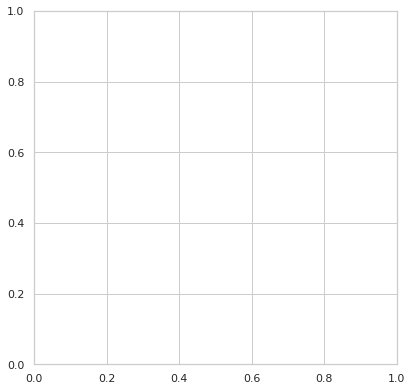

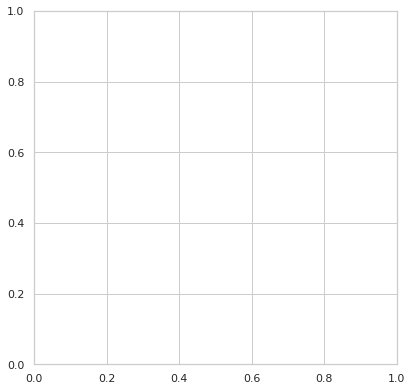

ValueError: x and y must be the same size

In [121]:
degree=1

fig,ax=plt.subplots(figsize=(6.5, 6.5))
for m in ["modelinfo","m+t-info","mets"]:  # methodsets.keys():
    XA=df.loc[df.params.isin(RosettasetA)][methodsets[m]]
    YA=df.loc[df.params.isin(RosettasetA)]["dockQ"]
    XB=df.loc[df.params.isin(RosettasetB)][methodsets[m]]
    YB=df.loc[df.params.isin(RosettasetB)]["dockQ"]
    polyregA=make_pipeline(PolynomialFeatures(degree),LinearRegression())
    polyregB=make_pipeline(PolynomialFeatures(degree),LinearRegression())
    polyregA.fit(XA,YA)
    polyregB.fit(XB,YB)
    predA=polyregB.predict(XA)
    predB=polyregA.predict(XB)
    err=mean_squared_error(predA,YA)
    errB=mean_squared_error(predB,YB)
    fig2,ax2=plt.subplots(figsize=(6.5, 6.5))
    correctA=YA>cutoff
    correctB=YB>cutoff
    #fig2.show()

    correct=pd.concat([correctA,correctB])
    Y=pd.concat([YA,YB])
    print (predA,predB)
    print (predA.shape,predB.shape)
    ax2.scatter(Y,pred)
    pred=np.hstack((predA,predB))
    #fig2.show()
    fpr, tpr, threshold = metrics.roc_curve(correct, pred)
    roc_auc = metrics.auc(fpr, tpr)
    corr=np.corrcoef(Y,pred)


    tempdfA=df.loc[df.params.isin(RosettasetA)].copy()
    tempdfA["pred"]=predA
    tempdfB=df.loc[df.params.isin(RosettasetB)].copy()
    tempdfB["pred"]=predB

    tempdf=pd.concat([tempdfA,tempdfB])
    #tempdf=df.loc[df.params.isin(RosettasetA+RosettasetB)].copy()
    bestdf=tempdf.loc[df.params.isin(RosettasetA)].sort_values("pred",ascending=False).groupby(["code"]).first()
    #print (bestdf[["CODE","dockQ","mmd"]])
    c=sum(bestdf["dockQ"]>cutoff)
    s=sum(bestdf["dockQ"])/len(bestdf)
    topdf=tempdf.loc[df.params.isin(Rosettaset)].sort_values("dockQ",ascending=False).groupby(["code"]).first()
    #print (topdf[["CODE","dockQ","mmd"]])
    t=sum(topdf["dockQ"]>cutoff)
    S=sum(topdf["dockQ"])/len(topdf)
    #print ("test",sum(correct),corr[0,1],c,t,s,S)
    rmsd=np.sqrt(np.sum((pred-Y)**2))/len(pred)
    textstr = '\n'.join((
        r'correct=%d (%d)' % (c,t ),
        r'sum=%.3f (%.3f)' % (s,S ),
        r'R=%.3f ' % (corr[0,1] ),
        r'R Y>c=%.3f ' % (corr2[0,1] ),
        r'RMSD=%.1e ' % (rmsd ),
    ))



    ax2.text(0.05, 0.8, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
    ax2.set_title('Scatter pred vs real dockQ: '+m)
    ax2.set_xlim([0, 0.7])
    ax2.set_ylim([0, 0.7])
    ax2.plot([0, 1], [0, 1],'r--')
    #ax2.plot([0, 0.23], [1, 0.23],'g--')
    #ax2.plot([0.23, 0], [0.23, 1],'g--')
    ax2.set_ylabel('Predicted dockQ')
    ax2.set_xlabel('dockQ')
    #fig2.savefig("scatterpred-poly-"+m+".png",bbox_inches="tight")
    plt.show()
    ax.plot(fprB, tprB, label = m+': AUC = %0.2f' % roc_auc)
    ax.set_title('Receiver Operating Characteristic: ')
    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
#fig.savefig("ROC-poly.png",bbox_inches="tight")
plt.close(fig="all")    



In [122]:
mets=[ 'MMdock', 'cdhit', 'long', 'tmAB', 'longPPVMODEL','log-avprob','hhprob']

In [123]:
corrcut=0.23
degree=4
for m in mets:
    methods=[]
    for n in mets:
        if n!=m:
            methods+=[n]
    print (methods)
    X=df.loc[df.params.isin(Rosettaset)][methods]
    Y=df.loc[df.params.isin(Rosettaset)]["dockQ"]
    polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
    polyreg.fit(X,Y)
    pred=polyreg.predict(X)
    err=mean_squared_error(pred,Y)
    #fig2.show()
    correct=Y>cutoff
    fpr, tpr, threshold = metrics.roc_curve(correct, pred)
    roc_auc = metrics.auc(fpr, tpr)
    corr=np.corrcoef(Y,pred)
    Y2=Y.loc[Y>corrcut]
    X2=X.loc[Y>corrcut]
    pred2=polyreg.predict(X2)
    corr2=np.corrcoef(Y2,pred2)
    tempdf=df.loc[df.params.isin(Rosettaset)].copy()
    tempdf["pred"]=pred
    bestdf=tempdf.loc[df.params.isin(Rosettaset)].sort_values("pred",ascending=False).groupby(["code"]).first()
    #print (bestdf[["CODE","dockQ","mmd"]])
    c=sum(bestdf["dockQ"]>cutoff)
    s=sum(bestdf["dockQ"])/len(bestdf)
    topdf=tempdf.loc[df.params.isin(Rosettaset)].sort_values("dockQ",ascending=False).groupby(["code"]).first()
    #print (topdf[["CODE","dockQ","mmd"]])
    t=sum(topdf["dockQ"]>cutoff)
    S=sum(topdf["dockQ"])/len(topdf)
    rmsd=np.sqrt(np.sum((pred-Y)**2))/len(pred)
    #print ("test",sum(correct),corr[0,1],c,t,s,S)

    textstr =(         r'All except %s ' % (m),
        r'correct=%d (%d)' % (c,t ),
        r'sum=%.3f (%.3f)' % (s,S ),
        r'R=%.3f ' % (corr[0,1] ),
        r'R Y>c=%.3f ' % (corr2[0,1] ),
        r'RMSD=%.1e ' % (rmsd )
    )
    print (textstr)
    
    


['cdhit', 'long', 'tmAB', 'longPPVMODEL', 'log-avprob', 'hhprob']
('All except MMdock ', 'correct=12 (15)', 'sum=0.043 (0.070)', 'R=0.881 ', 'R Y>c=0.537 ', 'RMSD=4.7e-04 ')
['MMdock', 'long', 'tmAB', 'longPPVMODEL', 'log-avprob', 'hhprob']
('All except cdhit ', 'correct=8 (15)', 'sum=0.036 (0.070)', 'R=0.682 ', 'R Y>c=0.400 ', 'RMSD=8.4e-04 ')
['MMdock', 'cdhit', 'tmAB', 'longPPVMODEL', 'log-avprob', 'hhprob']
('All except long ', 'correct=8 (15)', 'sum=0.036 (0.070)', 'R=0.626 ', 'R Y>c=0.188 ', 'RMSD=1.0e-03 ')
['MMdock', 'cdhit', 'long', 'longPPVMODEL', 'log-avprob', 'hhprob']
('All except tmAB ', 'correct=9 (15)', 'sum=0.039 (0.070)', 'R=0.893 ', 'R Y>c=0.524 ', 'RMSD=4.5e-04 ')
['MMdock', 'cdhit', 'long', 'tmAB', 'log-avprob', 'hhprob']
('All except longPPVMODEL ', 'correct=9 (15)', 'sum=0.039 (0.070)', 'R=0.882 ', 'R Y>c=0.523 ', 'RMSD=4.7e-04 ')
['MMdock', 'cdhit', 'long', 'tmAB', 'longPPVMODEL', 'hhprob']
('All except log-avprob ', 'correct=10 (15)', 'sum=0.041 (0.070)', 'R=0.

In [124]:
tempdfA.pred

11009    0.020975
11010    0.018391
11011    0.004709
11012    0.003550
11013    0.017729
           ...   
11313    0.001979
11314    0.003185
11315    0.045100
11316    0.044384
11317    0.005260
Name: pred, Length: 309, dtype: float64

In [125]:
mets=[ 'PconsDock','Mdock', 'pcd', 'mmd', 'cdhit', 'log-cdhit',
       'shortpdb', 'log-hhprob', 'log-avprob', 'long', 'tmAB',
       'longMODEL', 'longPPVMODEL']

mets=[ 'PconsDock', 'pcd','MMdock','mmd', 'cdhit', 'long', 'tmAB', 'longPPVMODEL','log-avprob']



In [126]:
print (mets)
print (modset+seqset+predset+tmset)

['PconsDock', 'pcd', 'MMdock', 'mmd', 'cdhit', 'long', 'tmAB', 'longPPVMODEL', 'log-avprob']
['PconsDock', 'MMdock', 'pcd', 'mmd', 'cdhit', 'log-hhprob', 'log-avprob', 'long', 'tmAB', 'longPPVMODEL']


In [127]:
corrcut=0.23
degree=4
for m in modset+seqset+predset+tmset:
    if m in mets:
        continue
    else:
        methods=mets+[m]
    print (methods)
    X=df.loc[df.params.isin(Rosettaset)][methods]
    Y=df.loc[df.params.isin(Rosettaset)]["dockQ"]
    polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
    polyreg.fit(X,Y)
    pred=polyreg.predict(X)
    err=mean_squared_error(pred,Y)
    #fig2.show()
    correct=Y>cutoff
    fpr, tpr, threshold = metrics.roc_curve(correct, pred)
    roc_auc = metrics.auc(fpr, tpr)
    corr=np.corrcoef(Y,pred)
    Y2=Y.loc[Y>corrcut]
    X2=X.loc[Y>corrcut]
    pred2=polyreg.predict(X2)
    corr2=np.corrcoef(Y2,pred2)
    tempdf=df.loc[df.params.isin(Rosettaset)].copy()
    tempdf["pred"]=pred
    bestdf=tempdf.loc[df.params.isin(Rosettaset)].sort_values("pred",ascending=False).groupby(["code"]).first()
    #print (bestdf[["CODE","dockQ","mmd"]])
    c=sum(bestdf["dockQ"]>cutoff)
    s=sum(bestdf["dockQ"])/len(bestdf)
    topdf=tempdf.loc[df.params.isin(Rosettaset)].sort_values("dockQ",ascending=False).groupby(["code"]).first()
    #print (topdf[["CODE","dockQ","mmd"]])
    t=sum(topdf["dockQ"]>cutoff)
    S=sum(topdf["dockQ"])/len(topdf)
    rmsd=np.sqrt(np.sum((pred-Y)**2))/len(pred)
    #print ("test",sum(correct),corr[0,1],c,t,s,S)

    textstr =(r'Added %s ' % (m),
        r'correct=%d (%d)' % (c,t ),
        r'sum=%.3f (%.3f)' % (s,S ),
        r'R=%.3f ' % (corr[0,1] ),
        r'R Y>c=%.3f ' % (corr2[0,1] ),
        r'RMSD=%.1e ' % (rmsd )
    )
    print (textstr)
    
    


['PconsDock', 'pcd', 'MMdock', 'mmd', 'cdhit', 'long', 'tmAB', 'longPPVMODEL', 'log-avprob', 'log-hhprob']
('Added log-hhprob ', 'correct=13 (15)', 'sum=0.048 (0.070)', 'R=0.933 ', 'R Y>c=0.776 ', 'RMSD=3.6e-04 ')


In [128]:
df.PconsDock

0        0.685
1        0.685
2        0.684
3        0.684
4        0.000
         ...  
22229    0.642
22230    0.665
22231    0.665
22232    0.670
22233    0.670
Name: PconsDock, Length: 22234, dtype: float64

In [129]:
is_numeric_dtype(df["PconsDock"])

True

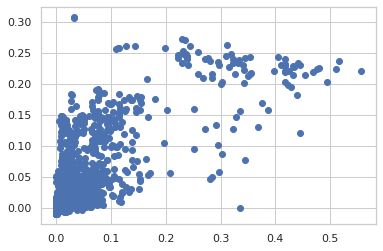

In [130]:

#Edit: added second square bracket above to fix the ValueError problem
reg=LinearRegression()
degree=1
X=df.loc[df.params.isin(Rosettaset)][modset+tmset+seqset]
Y=df.loc[df.params.isin(Rosettaset)]["dockQ"]
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg.fit(X,Y)
pred=polyreg.predict(X)
#df.loc[df.params.isin(Rosettaset)]["polypred"]=pred
df["polypred"]=polyreg.predict(df[modset+tmset+seqset])
plt.scatter(df.loc[df.params.isin(RosettasetAll)]["dockQ"],df[df.params.isin(RosettasetAll)]["polypred"])


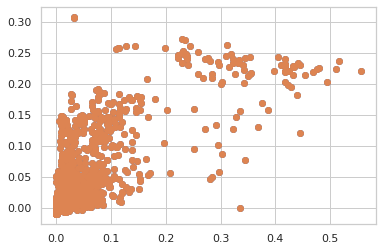

In [131]:
plt.scatter(df.loc[df.params.isin(Rosettaset)]["dockQ"],df[df.params.isin(Rosettaset)]["polypred"])
plt.scatter(df.loc[df.params.isin(RosettasetAll)]["dockQ"],df[df.params.isin(RosettasetAll)]["polypred"])


<ipython-input-132-f6293df57f7d>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2,ax2=plt.subplots(figsize=(6.5, 6.5))
<ipython-input-132-f6293df57f7d>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2,ax2=plt.subplots(figsize=(6.5, 6.5))


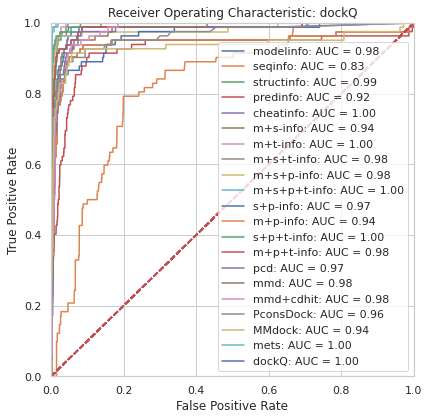

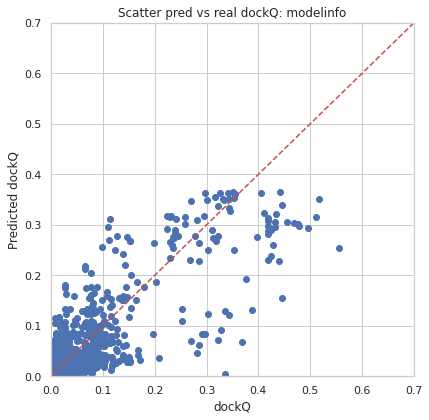

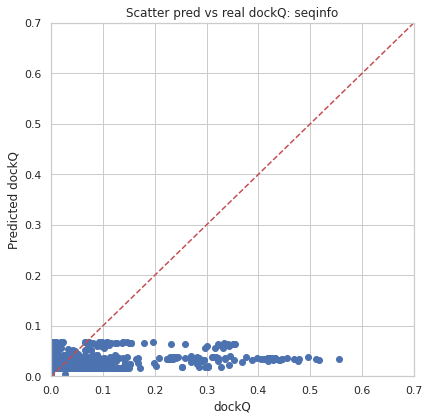

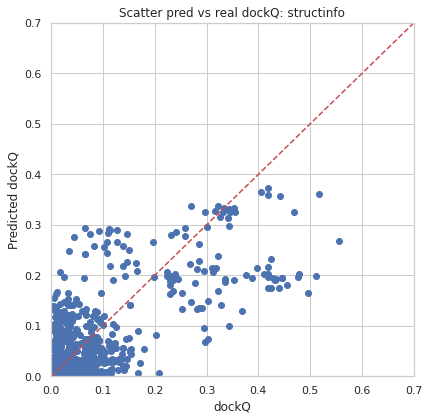

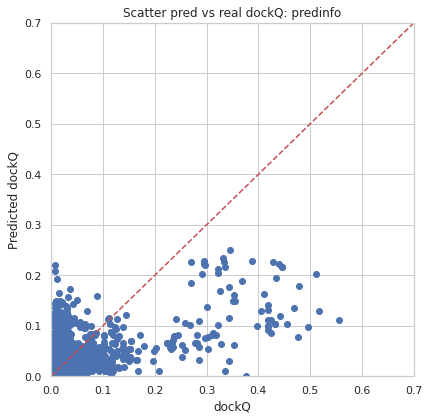

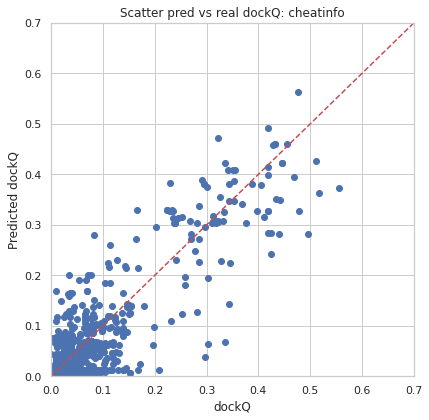

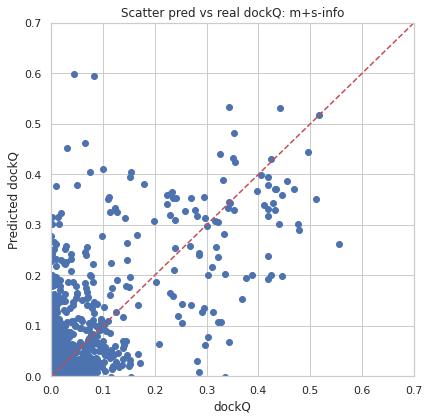

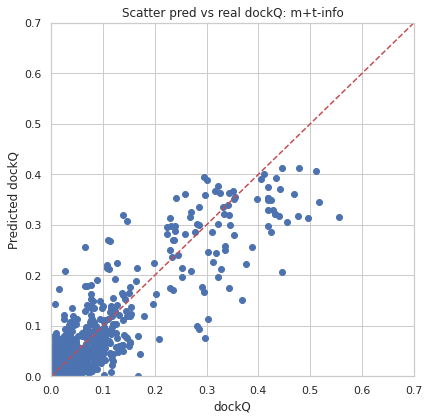

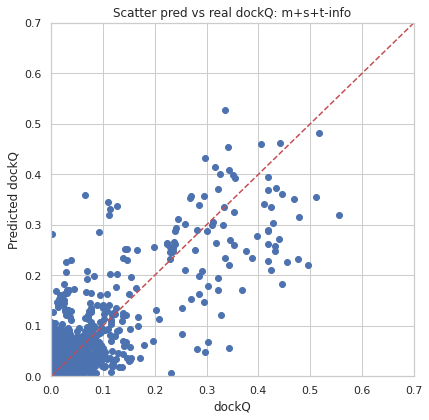

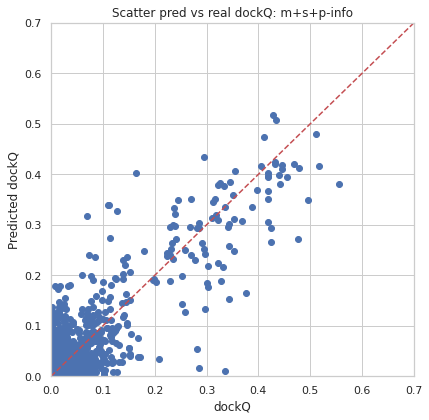

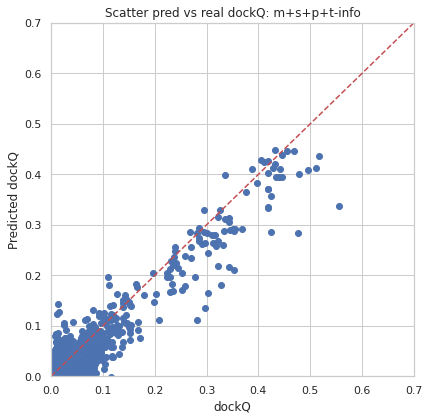

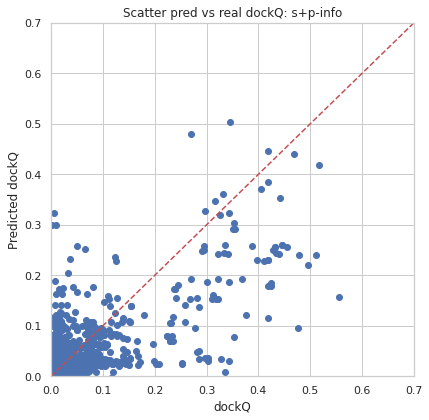

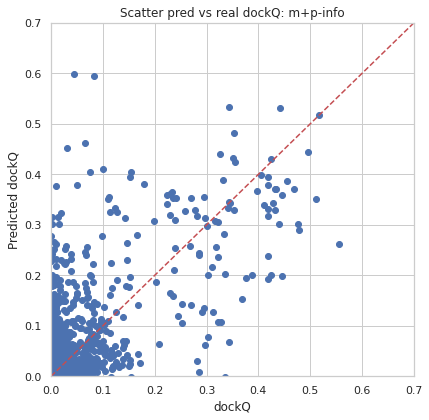

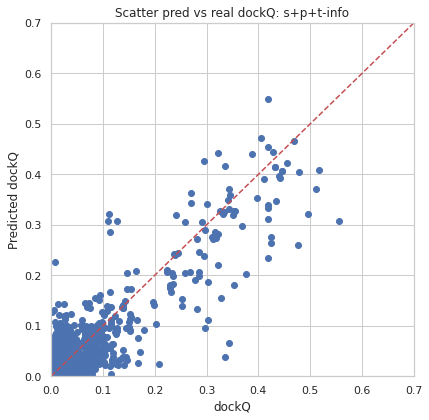

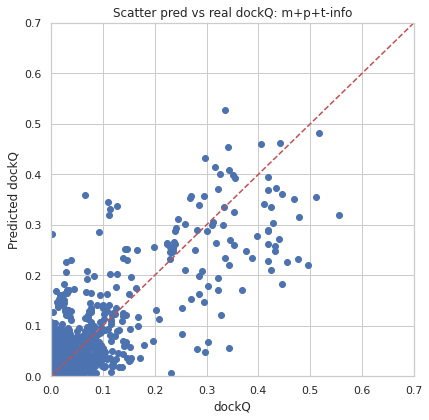

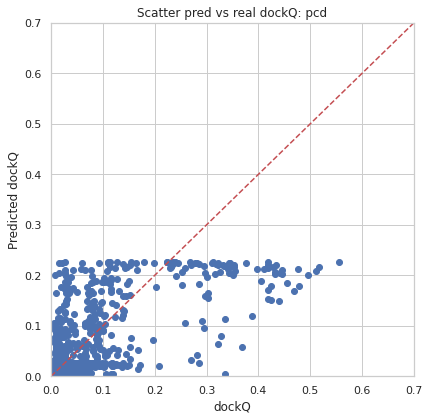

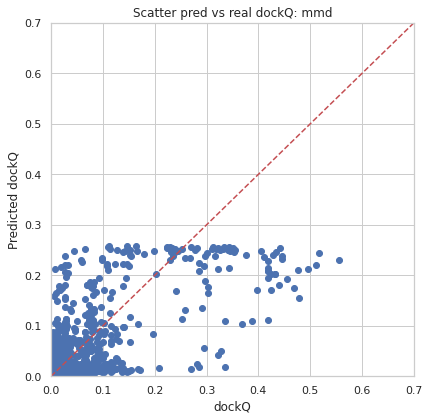

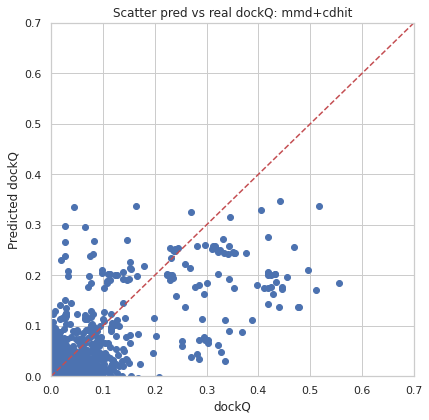

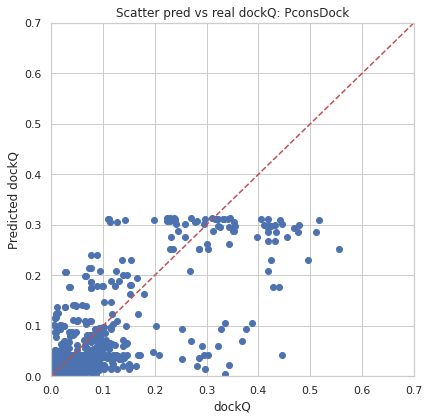

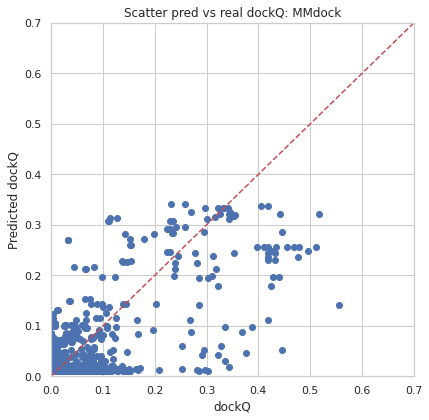

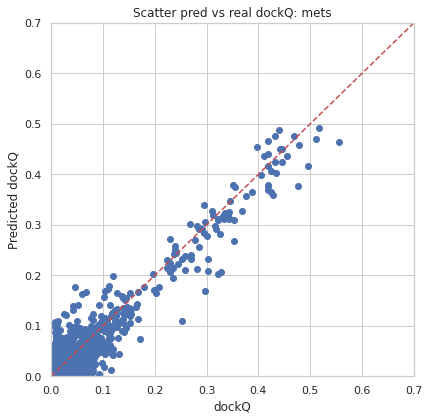

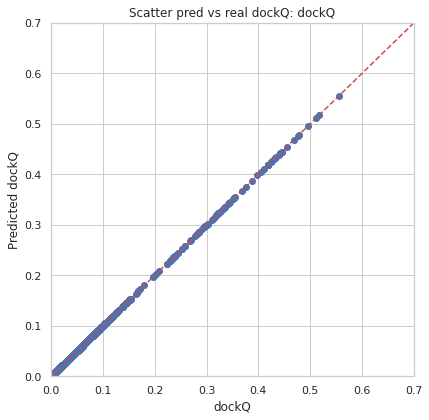

In [132]:
#Edit: added second square bracket above to fix the ValueError problem
reg=LinearRegression()
degree=4

fig,ax=plt.subplots(figsize=(6.5, 6.5))
for m in methodsets.keys():
    X=df.loc[df.params.isin(Rosettaset)][methodsets[m]]
    Y=df.loc[df.params.isin(Rosettaset)]["dockQ"]
    polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
    polyreg.fit(X,Y)
    pred=polyreg.predict(X)
    err=mean_squared_error(pred,Y)
    fig2,ax2=plt.subplots(figsize=(6.5, 6.5))
    ax2.scatter(Y,pred)
    #fig2.show()
    correct=Y>0.23
    fpr, tpr, threshold = metrics.roc_curve(correct, pred)
    roc_auc = metrics.auc(fpr, tpr)
    corr=np.corrcoef(Y,pred)
    ax2.set_title('Scatter pred vs real dockQ: '+m)
    ax2.set_xlim([0, 0.7])
    ax2.set_ylim([0, 0.7])
    ax2.plot([0, 1], [0, 1],'r--')
    #ax2.plot([0, 0.23], [1, 0.23],'g--')
    #ax2.plot([0.23, 0], [0.23, 1],'g--')
    ax2.set_ylabel('Predicted dockQ')
    ax2.set_xlabel('dockQ')

    fig2.savefig("scatter-"+m+".png",bbox_inches="tight")
    ax.plot(fpr, tpr, label = m+': AUC = %0.2f' % roc_auc)
    ax.set_title('Receiver Operating Characteristic: '+m)
    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

#fig.savefig("ROC.png",bbox_inches="tight")

In [133]:
bestdf=df.loc[df.params.isin(["trRosetta"])].sort_values("mmd",ascending=False).groupby(["code"]).first()
bestdf[["CODE","dockQ","mmd"]]

CODE  dockQ       mmd
code                       
1ay7  1ay7  0.312  0.827300
1b27  1b27  0.229  0.827110
1bdj  1bdj  0.023  0.639690
1buh  1buh  0.011  0.653963
1bvn  1bvn  0.011  0.561345
...    ...    ...       ...
5bmu  5bmu  0.080  0.757090
5brr  5brr  0.017  0.666960
5cec  5cec  0.000  0.525902
5cra  5cra  0.008  0.552170
5eg3  5eg3  0.015  0.650133

[221 rows x 3 columns]

In [134]:
df.cdhit_min


AttributeError: 'DataFrame' object has no attribute 'cdhit_min'

In [142]:
outlist=["mmd_min","cdhit_min","long_min","med_max","longMCCMODEL_min","num","numgood","nummod","numgoodmod","frac","fracmod"]

finalset=[
     {"cdhit_min":0,"long_min":0, "longMCCMODEL_min":0,"mmd_min":0},
     {"cdhit_min":30,"long_min":0,"longMCCMODEL_min":0,"mmd_min":0},
     {"cdhit_min":100,"long_min":0,"longMCCMODEL_min":0,"mmd_min":0},
     {"cdhit_min":300,"long_min":0,"longMCCMODEL_min":0,"mmd_min":0},
     {"cdhit_min":0,"long_min":0,"longMCCMODEL_min":0,"mmd_min":0,"hhprob_max":50},
     {"cdhit_min":30,"long_min":0,"longMCCMODEL_min":0,"mmd_min":0,"hhprob_max":50},
     {"cdhit_min":100,"long_min":0,"longMCCMODEL_min":0,"mmd_min":0,"hhprob_max":50},
     {"cdhit_min":300,"long_min":0,"longMCCMODEL_min":0,"mmd_min":0,"hhprob_max":50},
     {"cdhit_min":30,"med_max":0,"longMCCMODEL_min":0,"mmd_min":0},
     {"cdhit_min":30,"long_min":1,"longMCCMODEL_min":0,"mmd_min":0},
     {"cdhit_min":30,"long_min":5,"longMCCMODEL_min":0,"mmd_min":0},
     {"cdhit_min":30,"long_min":10,"longMCCMODEL_min":0,"mmd_min":0},
     {"cdhit_min":30,"long_min":0,"med_max":10,"mmd_min":0.},
     {"cdhit_min":30,"long_min":1,"med_max":10,"mmd_min":0.},
     {"cdhit_min":30,"long_min":10,"med_max":10,"mmd_min":0.},
     {"cdhit_min":30,"long_min":1,"longMCCMODEL_min":0.5,"mmd_min":0},
     {"cdhit_min":30,"long_min":1,"longMCCMODEL_min":0,"mmd_min":0.6},
     {"cdhit_min":30,"long_min":1,"longMCCMODEL_min":0.5,"mmd_min":0.6},
     {"cdhit_min":30,"long_min":1,"med_max":10,"longMCCMODEL_min":0.5,"mmd_min":0.6},
     {"cdhit_min":30,"long_min":1,"med_max":10,"longMCCMODEL_min":0.5,"pcd_min":0.4},
     {"cdhit_min":30,"long_min":1,"med_max":10,"longMCCMODEL_min":0.5,"MMdock_min":0.6},
     {"cdhit_min":30,"long_min":1,"med_max":10,"longMCCMODEL_min":0.5,"PconsDock_min":0.1},
     {"cdhit_min":30,"long_min":1,"med_max":10,"longMCCMODEL_min":0.5,"mmd_min":0.8,"pcd_min":0.4},
     {"cdhit_min":30,"long_min":1,"med_max":10,"longMCCMODEL_min":0.,"mmd_min":0.6},
     {"cdhit_min":30,"long_min":1,"med_max":10,"longMCCMODEL_min":0.,"pcd_min":0.4},
     {"cdhit_min":30,"long_min":1,"med_max":10,"longMCCMODEL_min":0.,"MMdock_min":0.6},
     {"cdhit_min":30,"long_min":1,"med_max":10,"longMCCMODEL_min":0.,"PconsDock_min":0.1},
     {"cdhit_min":30,"long_min":1,"med_max":10,"longMCCMODEL_min":0.,"mmd_min":0.8,"pcd_min":0.4},
     {"cdhit_min":30,"long_min":1,"med_max":0,"longMCCMODEL_min":0.5,"mmd_min":0.6},
     {"cdhit_min":30,"long_min":1,"med_max":0,"longMCCMODEL_min":0.5,"pcd_min":0.4},
     {"cdhit_min":30,"long_min":1,"med_max":0,"longMCCMODEL_min":0.5,"MMdock_min":0.6},
     {"cdhit_min":30,"long_min":1,"med_max":0,"longMCCMODEL_min":0.5,"PconsDock_min":0.1},
     {"cdhit_min":30,"long_min":1,"med_max":0,"longMCCMODEL_min":0.5,"mmd_min":0.8,"pcd_min":0.4},
    ]

df_final=pd.DataFrame()
for s in finalset:
    newdf=df.loc[(df.params.isin(Rosettaset))]
    d=s
    print (s)
    for k in s.keys():
        #print (k)
        if "_max" in k:
            key=k.replace("_max","")
            newdf=newdf.loc[newdf[key]<=s[k]]
        else:
            key=k.replace("_min","")
            newdf=newdf.loc[newdf[key]>=s[k]]
    #print(newdf)
    d.update(get_numexamples(newdf))
    df_final=df_final.append(pd.DataFrame.from_dict(d),ignore_index=True)        
df_final    

    

{'cdhit_min': 0, 'long_min': 0, 'longMCCMODEL_min': 0, 'mmd_min': 0}
{'cdhit_min': 30, 'long_min': 0, 'longMCCMODEL_min': 0, 'mmd_min': 0}
{'cdhit_min': 100, 'long_min': 0, 'longMCCMODEL_min': 0, 'mmd_min': 0}
{'cdhit_min': 300, 'long_min': 0, 'longMCCMODEL_min': 0, 'mmd_min': 0}
{'cdhit_min': 0, 'long_min': 0, 'longMCCMODEL_min': 0, 'mmd_min': 0, 'hhprob_max': 50}
{'cdhit_min': 30, 'long_min': 0, 'longMCCMODEL_min': 0, 'mmd_min': 0, 'hhprob_max': 50}
{'cdhit_min': 100, 'long_min': 0, 'longMCCMODEL_min': 0, 'mmd_min': 0, 'hhprob_max': 50}
{'cdhit_min': 300, 'long_min': 0, 'longMCCMODEL_min': 0, 'mmd_min': 0, 'hhprob_max': 50}
{'cdhit_min': 30, 'med_max': 0, 'longMCCMODEL_min': 0, 'mmd_min': 0}
{'cdhit_min': 30, 'long_min': 1, 'longMCCMODEL_min': 0, 'mmd_min': 0}
{'cdhit_min': 30, 'long_min': 5, 'longMCCMODEL_min': 0, 'mmd_min': 0}
{'cdhit_min': 30, 'long_min': 10, 'longMCCMODEL_min': 0, 'mmd_min': 0}
{'cdhit_min': 30, 'long_min': 0, 'med_max': 10, 'mmd_min': 0.0}
{'cdhit_min': 30, 'lon

cdhit_min  long_min  longMCCMODEL_min  mmd_min  num  numgood  nummod  \
0           0       0.0               0.0      0.0  221       15    3408   
1          30       0.0               0.0      0.0  190       15    2504   
2         100       0.0               0.0      0.0  177       13    1971   
3         300       0.0               0.0      0.0  133       11    1373   
4           0       0.0               0.0      0.0  200       13    3084   
5          30       0.0               0.0      0.0  169       13    2236   
6         100       0.0               0.0      0.0  157       11    1765   
7         300       0.0               0.0      0.0  116       10    1210   
8          30       NaN               0.0      0.0  185        9    2164   
9          30       1.0               0.0      0.0  131       15     914   
10         30       5.0               0.0      0.0  116       14     771   
11         30      10.0               0.0      0.0  106       13     677   
12         30       0.0               NaN      0.0  187       15    2377   
13         30       1.0               NaN      0.0  126       15     787   
14         30      10.0               NaN      0.0   97       13     539   
15         30       1.0               0.5      0.0   76       15     404   
16         30       1.0               0.0      0.6   83       15     416   
17         30       1.0               0.5      0.6   53       15     307   
18         30       1.0               0.5      0.6   40       15     184   
19         30       1.0               0.5      NaN   27       13     156   
20         30       1.0               0.5      NaN   34       12     168   
21         30       1.0               0.5      NaN   27       10     154   
22         30       1.0               0.5      0.8   15       11      91   
23         30       1.0               0.0      0.6   71       15     291   
24         30       1.0               0.0      NaN   37       13     181   
25         30       1.0               0.0      NaN   69       12     311   
26         30       1.0               0.0      NaN   42       10     197   
27         30       1.0               0.0      0.8   15       11      93   
28         30       1.0               0.5      0.6   31        9      93   
29         30       1.0               0.5      NaN   19        7      68   
30         30       1.0               0.5      NaN   29        7      86   
31         30       1.0               0.5      NaN   19        5      65   
32         30       1.0               0.5      0.8   10        5      27   

    numgoodmod      frac   fracmod  hhprob_max  med_max  pcd_min  MMdock_min  \
0           82  0.067873  0.024061         NaN      NaN      NaN         NaN   
1           82  0.078947  0.032748         NaN      NaN      NaN         NaN   
2           75  0.073446  0.038052         NaN      NaN      NaN         NaN   
3           73  0.082707  0.053168         NaN      NaN      NaN         NaN   
4           80  0.065000  0.025940        50.0      NaN      NaN         NaN   
5           80  0.076923  0.035778        50.0      NaN      NaN         NaN   
6           73  0.070064  0.041360        50.0      NaN      NaN         NaN   
7           72  0.086207  0.059504        50.0      NaN      NaN         NaN   
8           17  0.048649  0.007856         NaN      0.0      NaN         NaN   
9           82  0.114504  0.089716         NaN      NaN      NaN         NaN   
10          81  0.120690  0.105058         NaN      NaN      NaN         NaN   
11          80  0.122641  0.118168         NaN      NaN      NaN         NaN   
12          74  0.080214  0.031132         NaN     10.0      NaN         NaN   
13          74  0.119048  0.094028         NaN     10.0      NaN         NaN   
14          72  0.134020  0.133581         NaN     10.0      NaN         NaN   
15          82  0.197368  0.202970         NaN      NaN      NaN         NaN   
16          82  0.180723  0.197115         NaN      NaN    

In [143]:
df_final.to_csv("finalset.csv")

/home/arnee/.local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


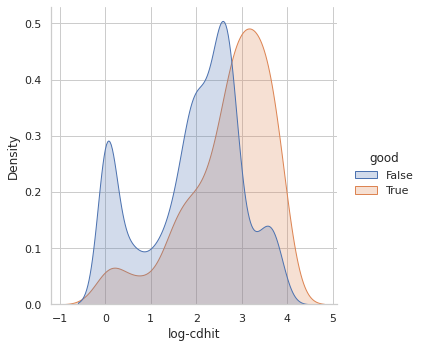

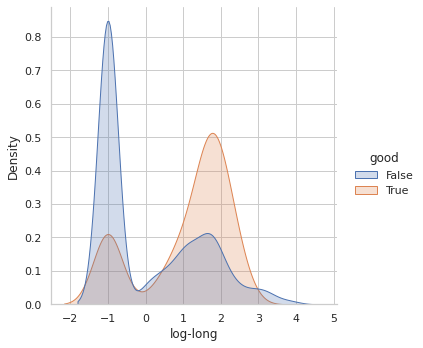

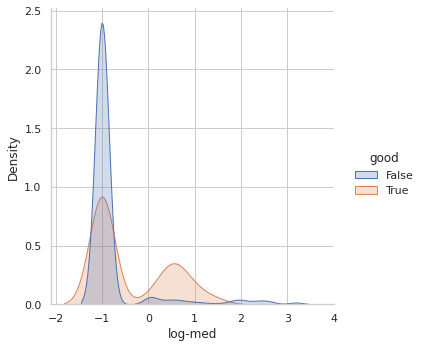

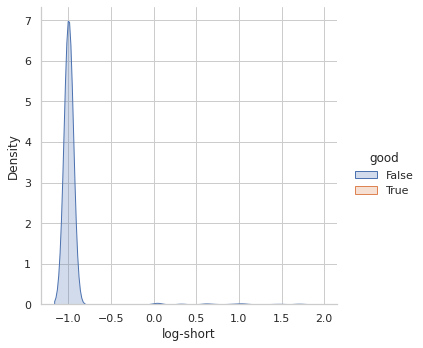

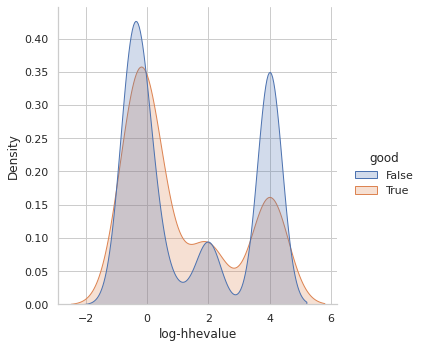

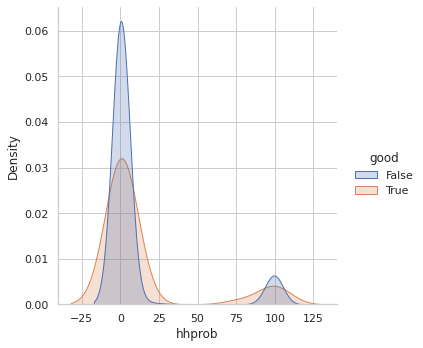

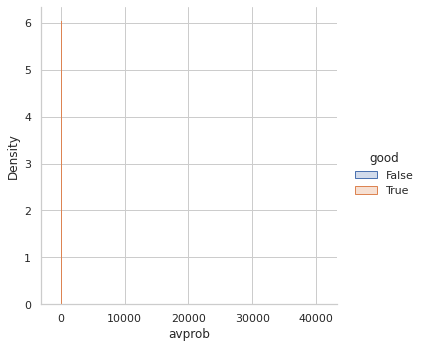

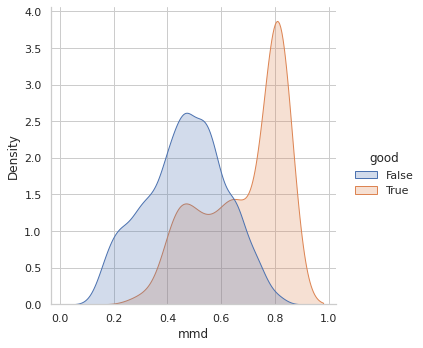

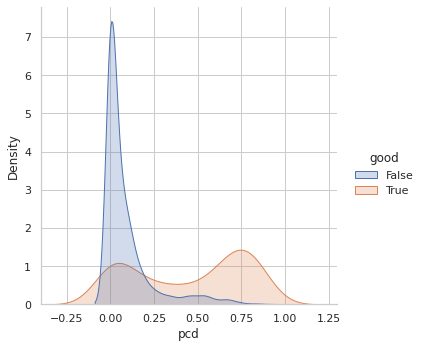

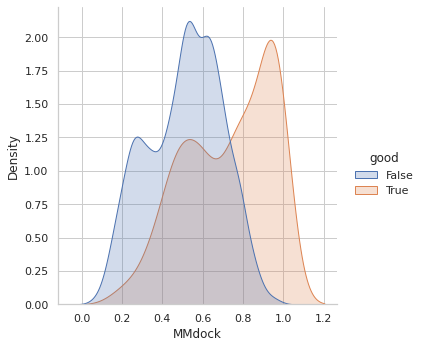

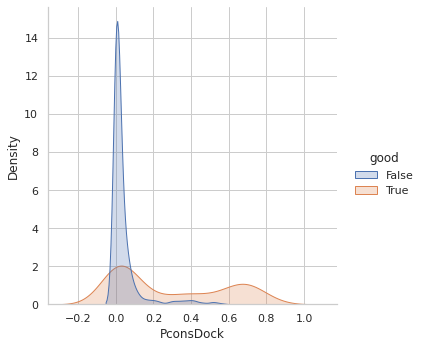

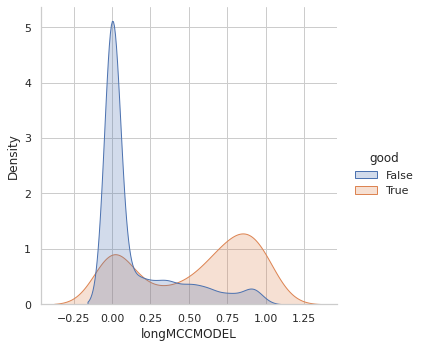

In [177]:
newdf=df.loc[df.params.isin(Rosettaset)]
baddf=df.loc[df.params.isin(Rosettaset)&(df.dockQ<cutoff)]
gooddf=df.loc[df.params.isin(Rosettaset)&(df.dockQ>=cutoff)]
#sns.displot(baddf,x="log-cdhit")
#sns.displot(gooddf,x="log-cdhit")
#sns.displot(newdf,x="log-cdhit",hue="good",multiple="dodge",stat="density",common_norm=False)
sns.displot(newdf,x="log-cdhit",hue="good",multiple="layer",kind="kde",common_norm=False,fill=True)
#sns.displot(newdf,x="log-long",hue="good",multiple="dodge",stat="density",common_norm=False)
sns.displot(newdf,x="log-long",hue="good",multiple="layer",kind="kde",common_norm=False,fill=True)
sns.displot(newdf,x="log-med",hue="good",multiple="layer",kind="kde",common_norm=False,fill=True)
sns.displot(newdf,x="log-short",hue="good",multiple="layer",kind="kde",common_norm=False,fill=True)
sns.displot(newdf,x="log-hhevalue",hue="good",multiple="layer",kind="kde",common_norm=False,fill=True)
sns.displot(newdf,x="hhprob",hue="good",multiple="layer",kind="kde",common_norm=False,fill=True)
#sns.displot(newdf,x="avprob",hue="good",multiple="layer",kind="kde",common_norm=False,fill=True)
sns.displot(newdf,x="mmd",hue="good",multiple="layer",kind="kde",common_norm=False,fill=True)
sns.displot(newdf,x="pcd",hue="good",multiple="layer",kind="kde",common_norm=False,fill=True)
sns.displot(newdf,x="MMdock",hue="good",multiple="layer",kind="kde",common_norm=False,fill=True)
sns.displot(newdf,x="PconsDock",hue="good",multiple="layer",kind="kde",common_norm=False,fill=True)
sns.displot(newdf,x="longMCCMODEL",hue="good",multiple="layer",kind="kde",common_norm=False,fill=True)


In [65]:
newdf=df.loc[df.params.isin(Rosettaset)]
baddf=df.loc[df.params.isin(Rosettaset)&(df.dockQ<cutoff)]
gooddf=df.loc[df.params.isin(Rosettaset)&(df.dockQ>=cutoff)]


/home/arnee/.local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


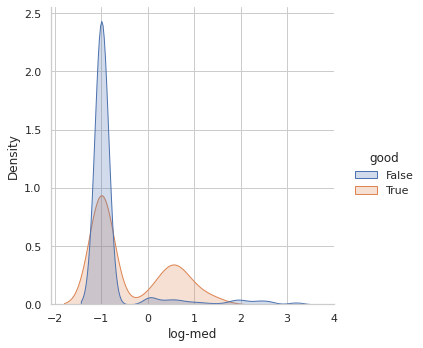

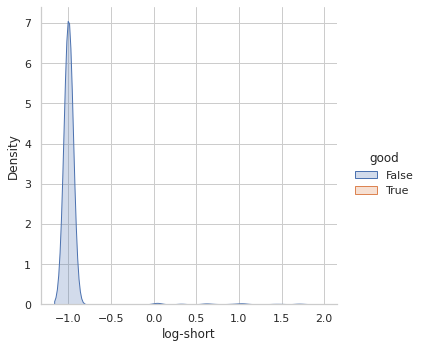

In [59]:
#sns.displot(newdf,x="med",hue="good")
sns.displot(newdf,x="log-med",hue="good",multiple="layer",kind="kde",common_norm=False,fill=True)
sns.displot(newdf,x="log-short",hue="good",multiple="layer",kind="kde",common_norm=False,fill=True)


In [66]:
 # seaborn.jointplot(*, x=None, y=None, data=None, kind='scatter', color=None, height=6, ratio=5, space=0.2, dropna=False, xlim=None, ylim=None, marginal_ticks=False, joint_kws=None, marginal_kws=None, hue=None, palette=None, hue_order=None, hue_norm=None, **kwargs)
# kind{ “scatter” | “kde” | “hist” | “hex”  #  | “reg” | “resid” }

 #   Kind of plot to draw. See the examples for references to the underlying functions.
x=len(newdf.loc[newdf.good==True])
y=len(newdf.loc[newdf.good==False])
print(x,y)
tempdf=newdf.loc[newdf.good==True].copy()
len(tempdf)


263 3479


263

In [62]:
len(newdf)

3742

In [63]:
newdf=pd.concat([newdf,tempdf], ignore_index=True,sort=False)
len(newdf)

4005

In [67]:
x=len(newdf.loc[newdf.good==True])
y=len(newdf.loc[newdf.good==False])
print(x,y)

tempdf=newdf.loc[newdf.good==True].copy()

for i in range(1,int(y/x)):
    print (i)
    #tempdf["copynumber"]=i
    newdf=pd.concat([newdf,tempdf], ignore_index=True,sort=False)

x=len(newdf.loc[newdf.good==True])
y=len(newdf.loc[newdf.good==False])
print(x,y)


263 3479
1
2
3
4
5
6
7
8
9
10
11
12
3419 3479


In [57]:
tempdf


name JHparams lenA lenB   msa    msaA    msaB cdhit  \
0       1ay7_u1_A-1ay7_u2_A       N3   97   90  1060    1485    2034  1026   
1       1ay7_u2_A-1ay7_u1_A       N3   90   97  1060    2034    1485   989   
2       1b27_u1_A-1b27_u2_A       N3  109   90   733    1484    2034   654   
3       1b27_u2_A-1b27_u1_A       N3   90  109   733    2034    1484   656   
34      1gpw_u1_A-1gpw_u2_A       N3  252  204  7137   58466   67629  5348   
...                     ...      ...  ...  ...   ...     ...     ...   ...   
542098  4bmp_u2_A-4bmp_u1_A       N5  118  301  4607   15729    9429  2894   
542099  4gmj_u1_A-4gmj_u2_A       N5  253  236  1189    6344    1653   523   
542100  4gmj_u2_A-4gmj_u1_A       N5  236  253  1189    1653    6344   546   
542101  4txo_u1_A-4txo_u2_A       N5  178  158  7106  131653  115265  6529   
542102  4txo_u2_A-4txo_u1_A       N5  158  178  7106  115265  131653  6530   

        dockQ   fnat  ...  numcorrect  len  log-cdhit  log-avprob  log-hhprob  \
0       0.281  0.167  ...      53.985  187   3.011190   -0.681937   -0.301030   
1       0.239  0.250  ...      43.992  187   2.995240   -0.673664   -1.000000   
2       0.223  0.120  ...      49.025  199   2.815644   -0.707744    0.278754   
3       0.229  0.160  ...       46.02  199   2.816970   -0.701147    0.414973   
34      0.351  0.320  ...      96.033  456   3.728200   -0.759451    0.113943   
...       ...    ...  ...         ...  ...        ...         ...         ...   
542098  0.000  0.000  ...           0  419   3.461514   -0.876148   -0.045757   
542099  0.296  0.634  ...     139.104  489   2.718585   -0.643974   -0.096910   
542100  0.445  0.780  ...     133.061  489   2.737272   -0.640165   -0.154902   
542101  0.033  0.023  ...           1  336   3.814853   -0.801343    2.000000   
542102  0.014  0.000  ...       1.026  336   3.814920   -0.769551    2.000000   

        log-long   log-med log-short  log-hhevalue  good  
0       1.786041  0.491362      -1.0     -0.301030  True  
1       1.716838  0.612784      -1.0      3.999961  True  
2       1.725095  0.491362      -1.0      0.278754  True  
3       1.716838  0.491362      -1.0      0.414973  True  
34      2.075912  0.322219      -1.0      0.113943  True  
...          ...       ...       ...           ...   ...  
542098 -1.000000 -1.000000      -1.0     -0.045757  True  
542099  2.459543  1.082785      -1.0     -0.096910  True  
542100  2.433130  1.045323      -1.0     -0.154902  True  
542101  1.399674 -1.000000      -1.0      2.000000  True  
542102  1.733197 -1.000000      -1.0      2.000000  True  

[538624 rows x 101 columns]

/home/arnee/.local/lib/python3.8/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'marginal_ticks'
  cset = contour_func(


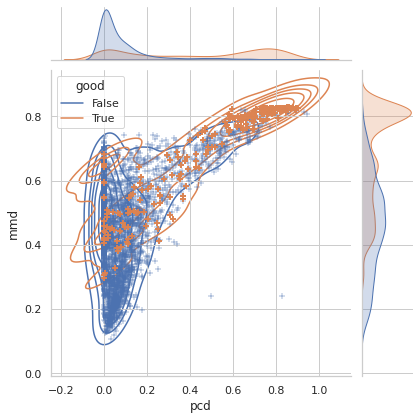

In [69]:
g=sns.jointplot(data=newdf, x="pcd", y="mmd",hue="good",kind="scatter",marker="+")
#g.plot_joint(sns.jointplot, x="pcd", y="mmd",hue="good",kind="kde")
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6,marginal_ticks=True)
g.savefig("jointplot-good-bad-"+k+"-"+l+".png",bbox_inches="tight")

#g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)
#g = sns.jointplot(X, y, kind='reg', scatter = False )


NameError: name 'sns_plot' is not defined

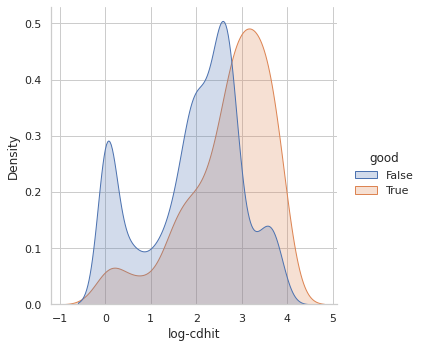

NameError: name 'sns_plot' is not defined

In [189]:
keys=["log-cdhit","pcd"]
for k in keys:
    sns_plot=sns.displot(newdf,x=k,hue="good",multiple="layer",kind="kde",common_norm=False,fill=True)
    f=sns_plot.get_figure()
    f.savefig("displot-good-bad-"+k+".png",bbox_inches="tight")
    for l in keys:
        if k<=l: continue
        sns_plot=sns.jointplot(data=newdf, x=k, y=l,hue="good",kind="kde")
        f=sns_plot.get_figure()
        f.savefig("jointplot-good-bad-"+k+"-"+l+".png",bbox_inches="tight")


In [155]:
df[(df.hhprob>95)&(df.dockQ>.2)&(df.params.isin(Rosettaset))][["name","params","dockQ"]]




name              params  dockQ
20407  4txo_u1_A-4txo_u2_A  N1-cov90-minprob25  0.230
21275  4txo_u1_A-4txo_u2_A        N1-minprob25  0.285
21465  2hrk_u1_A-2hrk_u2_A         N1-N3-cov90  0.326
21897  2hrk_u1_A-2hrk_u2_A     N1-N3-cov-nocov  0.330
22574  4txo_u2_A-4txo_u1_A           N1-N3-new  0.211
24292  4txo_u1_A-4txo_u2_A  N3-cov90-minprob25  0.232
24293  4txo_u2_A-4txo_u1_A  N3-cov90-minprob25  0.224
24485  2hrk_u1_A-2hrk_u2_A            N3-cov90  0.344

TypeError: The y variable is categorical, but one of ['numeric', 'datetime'] is required

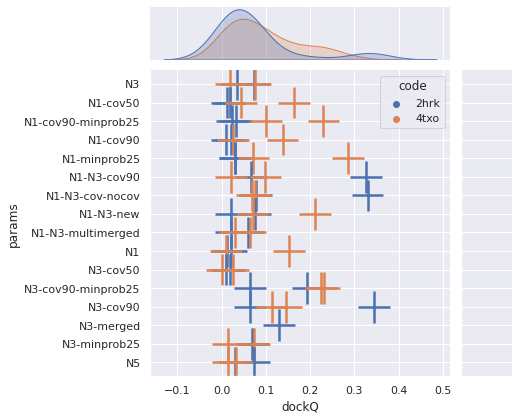

TypeError: The y variable is categorical, but one of ['numeric', 'datetime'] is required

In [163]:
tempdf=df.loc[df.code.isin(["4txo","2hrk"])&(df.params.isin(Rosettaset))]
sns.jointplot(data=tempdf,y="params",x="dockQ",kind="scatter",marker="+",hue="code",s=1000)

In [175]:
tempdf=df.loc[df.params.isin(Rosettaset)]
grpdf=tempdf.groupby(["code","params"]).max()

In [176]:
grpdf


name      JHparams  lenA  lenB   msa  \
code params                                                              
1ay7 N1            1ay7_u2_A-1ay7_u1_A            N1    97    97     2   
     N1-cov90      1ay7_u2_A-1ay7_u1_A      N1-cov90    97    97     1   
     N1-minprob25  1ay7_u2_A-1ay7_u1_A  N1-minprob25    97    97     2   
     N3            1ay7_u2_A-1ay7_u1_A            N3    97    97  1060   
     N3-cov90      1ay7_u2_A-1ay7_u1_A      N3-cov90    97    97   590   
...                                ...           ...   ...   ...   ...   
5eg3 N1-cov90      5eg3_u2_A-5eg3_u1_A      N1-cov90   303   303   264   
     N1-minprob25  5eg3_u2_A-5eg3_u1_A  N1-minprob25   303   303   305   
     N3            5eg3_u2_A-5eg3_u1_A            N3   303   303   421   
     N3-cov90      5eg3_u2_A-5eg3_u1_A      N3-cov90   303   303    15   
     N3-minprob25  5eg3_u2_A-5eg3_u1_A  N3-minprob25   303   303   421   

                     msaA    msaB  cdhit  dockQ   fnat  ...  len  log-cdhit  \
code params                                             ...                   
1ay7 N1               960     960      2  0.023  0.000  ...  187   0.322219   
     N1-cov90         960     960      1  0.017  0.000  ...  187   0.041393   
     N1-minprob25     960     960      2  0.043  0.083  ...  187   0.322219   
     N3              2034    2034   1026  0.281  0.250  ...  187   3.011190   
     N3-cov90        2034    2034    526  0.353  0.167  ...  187   2.721068   
...                   ...     ...    ...    ...    ...  ...  ...        ...   
5eg3 N1-cov90      147816  147816     73  0.017  0.000  ...  408   1.863917   
     N1-minprob25  147816  147816    105  0.015  0.000  ...  408   2.021603   
     N3            565997  565997    103  0.000  0.000  ...  408   2.013259   
     N3-cov90      565997  565997     15  0.010  0.000  ...  408   1.178977   
     N3-minprob25  565997  565997    205  0.014  0.000  ...  408   2.311966   

                   log-avprob  log-hhprob  log-long   log-med  log-short  \
code params                                                                
1ay7 N1             -0.037631    -1.00000  1.634477 -1.000000       -1.0   
     N1-cov90       -0.042872    -1.00000  1.748963 -1.000000       -1.0   
     N1-minprob25   -0.037631    -1.00000  1.634477 -1.000000       -1.0   
     N3             -0.003488    -0.30103  1.786041  0.612784       -1.0   
     N3-cov90        0.001734    -0.30103  1.613842 -1.000000       -1.0   
...                       ...         ...       ...       ...        ...   
5eg3 N1-cov90        0.002166     0.00000  1.117271 -1.000000       -1.0   
     N1-minprob25    0.008174     0.00000  1.117271 -1.000000       -1.0   
     N3              0.021603    -0.09691 -1.000000 -1.000000       -1.0   
     N3-cov90       -0.006123    -0.09691  0.322219 -1.000000       -1.0   
     N3-minprob25    0.021603    -0.09691 -1.000000 -1.000000       -1.0   

                   log-hhevalue   good  goodmodel  
code params                                        
1ay7 N1                3.999961   True      False  
     N1-cov90          3.999961   True      False  
     N1-minprob25      3.999961   True      False  
     N3                3.999961   True       True  
     N3-cov90          3.999961   True       True  
...                         ...    ...        ...  
5eg3 N1-cov90          0.000000  False      False  
     N1-minprob25      0.000000  False      False  
     N3               -0.096910  False      False  
     N3-cov90         -0.096910  False      False  
     N3-minprob25     -0.096910  False      False  

[1291 rows x 101 columns]

In [170]:
df_max

name  lenA  lenB   msa    msaA    msaB  \
JHparams       code                                                          
-N 1 -E 1.e-2  1ay7  1ay7_u2_A-1ay7_u1_A    97    97    33    1006    1006   
               1b27  1b27_u2_A-1b27_u1_A   109   109   162     326     326   
               1bdj  1bdj_u2_A-1bdj_u1_A   129   129   273  178189  178189   
               1buh  1buh_u2_A-1buh_u1_A   291   291  1022  528626  528626   
               1bvn  1bvn_u2_A-1bvn_u1_A    75   496    23      22    2244   
...                                  ...   ...   ...   ...     ...     ...   
trRosetta      4zfr  4zfr_u2_A-4zfr_u1_A   186   186  1358   38386   38386   
               5brr  5brr_u2_A-5brr_u1_A   378   378   611   45450   45450   
               5cec  5cec_u2_A-5cec_u1_A   403   403  1594  309307  309307   
               5cra  5cra_u2_A-5cra_u1_A   193   193     1   38383   38383   
               5eg3  5eg3_u2_A-5eg3_u1_A   303   303   421  565997  565997   

                     cdhit  dockQ   fnat     iRMS  ...  CODE          params  \
JHparams       code                                ...                         
-N 1 -E 1.e-2  1ay7     18  0.042  0.000  107.719  ...  1ay7  -N 1 -E 1.e-2    
               1b27     75  0.127  0.120    8.988  ...  1b27  -N 1 -E 1.e-2    
               1bdj     38  0.043  0.000   20.245  ...  1bdj  -N 1 -E 1.e-2    
               1buh     47  0.002  0.000  519.337  ...  1buh  -N 1 -E 1.e-2    
               1bvn      3  0.029  0.000   18.064  ...  1bvn  -N 1 -E 1.e-2    
...                    ...    ...    ...      ...  ...   ...             ...   
trRosetta      4zfr    504  0.050  0.013  297.804  ...  4zfr       trRosetta   
               5brr    550  0.028  0.055   22.035  ...  5brr       trRosetta   
               5cec   1577  0.050  0.075  732.223  ...  5cec       trRosetta   
               5cra      1  0.082  0.036   22.634  ...  5cra       trRosetta   
               5eg3    205  0.017  0.000  535.411  ...  5eg3       trRosetta   

                         tmAB     msaAB  tmAB_max  msaAB_max  tmAB_min  \
JHparams       code                                                      
-N 1 -E 1.e-2  1ay7  0.535730     645.0   0.54498     1006.0   0.52648   
               1b27  0.759635     294.0   0.83090      326.0   0.69511   
               1bdj  0.861555   89234.0   0.90026   178189.0   0.83211   
               1buh  0.706400  265286.0   0.73711   528626.0   0.67569   
               1bvn  0.321710    1133.0   0.36240     2244.0   0.28102   
...                       ...       ...       ...        ...       ...   
trRosetta      4zfr  0.823380   23838.0   0.86456    38386.0   0.78402   
               5brr  0.804985   29501.5   0.81110    45450.0   0.80210   
               5cec  0.791585  169964.0   0.87436   309307.0   0.70881   
               5cra  0.562420   19197.0   0.78769    38383.0   0.38116   
               5eg3  0.728535  295961.5   0.76252   565997.0   0.71274   

                     msaAB_min  numcorrect  len  
JHparams       code                              
-N 1 -E 1.e-2  1ay7      284.0       0.000  187  
               1b27      262.0      19.005  199  
               1bdj      279.0       0.000  247  
               1buh     1946.0       0.000  363  
               1bvn       22.0       0.000  571  
...                        ...         ...  ...  
trRosetta      4zfr     9290.0       0.000  263  
               5brr    13553.0       0.000  644  
               5cec    30621.0       1.040  594  
               5cra       11.0       3.003  270  
               5eg3    25926.0       0.000  408  

[7777 rows x 92 columns]

In [115]:
df.JHparams.unique()

array(['N3', 'AF2-merged', 'AF2-proteomes', 'AF2-smallBFD',
       'pyconsFold-contacts', 'pyconsFold-merged', 'confold-npz',
       'pyconsFold-pdb', 'confold-plm', 'pyconsFold', 'confold-raptorx',
       'gramm-contact', 'gramm', 'gramm-raptorx', 'gramm-score2',
       'gramm-score', 'gramm-trmodels', 'N1-all', '-N 1 -E 1.e-2 ',
       'N1-cov50', 'N1-cov90-minprob25', 'N1-cov90', 'N1-minprob25',
       'N1-N3-cov90', 'N1-N3-cov-nocov', 'N1-N3-new', 'N1-N3-multimerged',
       'N1', 'N3-all', 'N3-bact', 'N3-cov50', 'N3-cov90-minprob25',
       'N3-cov90', 'N3-merged', 'N3-minprob25', 'N3-pdb', 'N5',
       'pdbconfold', 'RaptorX', 'rbh-jh', 'rbh', 'TMdock-double',
       'TMdock-nohomology', 'TMdock', 'PconsDock', 'PconsDock-dockQ',
       'PconsDock-MMcons', 'PconsDock-dockQcons', 'PconsDock-MMpair',
       'PconsDock-dockQpair', 'Rosettaset-dockQpair', 'Rosettaset-MMpair',
       'Rosettaset-dockQcons', 'Rosettaset-MMcons', 'AF2set-dockQpair',
       'AF2set-MMpair', 'AF2set-dockQc

In [144]:
i="dockQ"
code="1ay7"
for i in grammset:
#tempdf
    average=df.loc[(df.JHparams==i)&(df["rank"]==1)]["dockQ"].mean()
    tm=df.loc[(df.JHparams==i)&(df["rank"]==1)]["TMscore"].mean()
    num=df.loc[(df.JHparams==i)&(df["rank"]==1)&(df.dockQ>0.23)]["dockQ"].count()
    len=df.loc[(df.JHparams==i)&(df["rank"]==1)]["dockQ"].count()

    print (i,average,tm,num,len)


gramm 0.064490990990991 0.9116711486486486 16 222
gramm-contact 0.045287037037037035 0.9962333101851852 8 216
gramm-trmodels 0.034 0.7370839269406393 1 219
gramm-raptorx 0.050592039800995026 0.9979930597014925 6 201


gramm-score 0.07282142857142856 0.9853496428571429 2 28
gramm-score2 0.10657142857142857 0.9853496428571429 5 28
